In [2]:
from abc import ABC, abstractmethod
import gymnasium as gym
import random
import numpy as np
import torch
import torch.nn as nn
from collections import OrderedDict
import math
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import copy
import seaborn as sns
import pandas as pd
import plotly.graph_objects as go
from matplotlib import cm
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans

In [3]:
### MLP
class Multi_Layer_Perceptron(nn.Sequential):
    def __init__(self, input_dim, intern_dim, output_dim, depth = 2, isBiased = False):
        
        dict = OrderedDict([("input",nn.Linear(input_dim,intern_dim, bias=isBiased))])
        for i in range(depth):
            dict.update({str(i) : nn.Linear(intern_dim,intern_dim,bias=isBiased)})
        dict.update({"output" : nn.Linear(intern_dim,output_dim,bias=isBiased)})

        super().__init__(dict)

        self.reset_init_weights_biases(0) # so that we do not use a default initialization

    def reset_init_weights_biases(self, norm = -1):
        for layer in self.children():
            stdv = 1. / math.sqrt(layer.weight.size(1))
            if norm != -1 :
                stdv = norm
            layer.weight.data.uniform_(-stdv,stdv)
            if layer.bias is not None:
                layer.bias.data.uniform_(-stdv,stdv)

In [4]:
class Agent(ABC):

    @abstractmethod
    def observe(self, state, action, next_state, reward):
        pass

    @abstractmethod
    def select_action(self, state):
        pass
    
    @abstractmethod
    def update(self):
        pass

    def __init__(self, id, env):
        self.id = id
        self.env = env
                

In [5]:
class RandomAgent(Agent):
    def observe(self, state, action, next_state, reward):
        pass
        
    def select_action(self, state):
        return self.env.action_space.sample()
        
    def update(self):
        pass

    '''
    Test the agent on a seed (random or not) after the training
    '''  
    def play(self, episodes, seed = False, debug_mode=False):
        episodesHistory = np.zeros((episodes))
        
        for i in range(episodes):
            if(debug_mode) : print("Episode: "+str(i+1)+" starts")
                
            newSeed = random.randint(0,100000)
            if seed != False:
                newSeed = seed
                
            state,_ = self.env.reset(seed = newSeed)
            done = False
            episode_reward = 0
            
            while not done:
                                        
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)

                episode_reward += reward
                state = next_state
                done = terminated or truncated
                
            self.env.close()
            episodesHistory[i] = episode_reward
            if(debug_mode) : print("Episode "+str(i+1)+ " , Reward: "+str(episode_reward))
        return episodesHistory

In [42]:
class DQNAgent(Agent):

    def __init__(self, id, epsilonMax=1, epsilonMin = 0.05, reward_factor = 0.5, predList_batch_size = 200, env = gym.make('MountainCar-v0'), arrayNewPosReward = None, gamma = 0.99, replay_buffer_SIZE = 10000, batch_size = 64, observation_SIZE = 6):
        Agent.__init__(self,id,env)
        '''
        Definition of MLP for the Policy + the RND
        '''
        self.Q = Multi_Layer_Perceptron(input_dim = 2,intern_dim = 64, output_dim = 3, depth = 2, isBiased = False) # For the policy
        self.QTarget = Multi_Layer_Perceptron(input_dim = 2,intern_dim = 64, output_dim = 3, depth = 2, isBiased = False)
        self.Pred = Multi_Layer_Perceptron(input_dim = 2,intern_dim = 64, output_dim = 1, depth = 2, isBiased = False) # For the RND
        self.PredTarget = Multi_Layer_Perceptron(input_dim = 2,intern_dim = 64, output_dim = 1, depth = 2, isBiased = False)
        '''
        Definition of the hyperparameters for the training
        '''
        self.arrayNewPosReward = arrayNewPosReward # Heuristic Rewards
        self.reward_factor = reward_factor # For the RND
        self.gamma = gamma
        self.epsilon = epsilonMax
        self.epsilonMax = epsilonMax
        self.epsilonMin = epsilonMin
        '''
        Definition of the replay buffer
        '''
        self.replay_buffer_SIZE = replay_buffer_SIZE
        self.observation_SIZE = observation_SIZE
        self.replay_buffer = np.zeros((replay_buffer_SIZE,observation_SIZE))
        self.batch_size = batch_size
        '''
        Definition of the optimizer + loss function (there are 2 for the Q + RND)
        '''        
        self.optimizer = torch.optim.AdamW(self.Q.parameters())
        self.optimizer2 = torch.optim.AdamW(self.Pred.parameters())     
        self.LossFct = torch.nn.MSELoss()
        self.LossFct2 = torch.nn.MSELoss()
        '''
        Definition of parameters for the computing of the normalization (for the RND)
        '''        
        self.next_state_mean = 0
        self.next_state_std = 1
        self.RND_std = 1
        self.RND_mean = 0
        self.PredList = [] #History to compute the normalization
        self.predList_batch_size = predList_batch_size # batch size to compute the normalization
        '''
        Definition of extra informations
        '''   
        self.last_success_seed = 0 # To facilitate the test after training
        self.j = 0 # nb of steps already done
        
    def observe(self, state, action, next_state, reward):
        state = np.array(state)
        action = np.array([action])
        next_state = np.array(next_state)
        reward = np.array([reward])
        concatenatation = np.concatenate((state, action, next_state, reward))

        self.replay_buffer[self.j%self.replay_buffer_SIZE] = concatenatation
        
    '''
    Select actions with exploration (for the training)
    '''          
    def select_action(self, state):
        P = random.uniform(0,1)
        a=0
        if P <= 1-self.epsilon :
            arg = self.Q(torch.from_numpy(state).to(torch.float32)).max(axis = 0)[1].numpy()
            if arg.size == 1:
                a = arg
            else:
                a = np.random.choice(arg, size = 1)[0]
        else:
            a = random.randint(0,2)
        return a
    '''
    Select actions without exploration (for the tests)
    '''  
    def select_best_action(self, state):
        a = 0
        arg = self.Q(torch.from_numpy(state).to(torch.float32)).max(axis = 0)[1].numpy()
        if arg.size == 1:
            a = arg
        else:
            a = np.random.choice(arg, size = 1)[0]
        return a
    '''
    Update the Q network (j: nb of epochs)
    '''  
    def update(self):
        batchIndex = np.random.choice(min(self.j+1,self.replay_buffer.shape[0]), self.batch_size)
        batch = self.replay_buffer[batchIndex,:]
        target = torch.zeros((self.batch_size))
        input = torch.zeros((self.batch_size))

        A = torch.from_numpy(batch[:,3:5]).to(torch.float32)
        
        QMax = self.QTarget(A).max(axis = 1)[0].detach().numpy()
        target = torch.from_numpy(batch[:,5] + self.gamma*QMax).to(torch.float32)
        
        for i in range(A.shape[0]):
            if A[i,0] >= 0.5:
                target[i] = batch[i,5]
                 
        input = self.Q(torch.from_numpy(batch[:,:2]).to(torch.float32))[np.arange(batch.shape[0]),batch[:,2]]
        loss = self.LossFct(input, target)
        self.optimizer.zero_grad()  
        loss.backward()
        self.optimizer.step()
        
        if self.j%refreshQTarget == 0:
            self.QTarget.load_state_dict(self.Q.state_dict())

        grad = 0
        for layer in self.Q.children():
            grad += abs(layer.weight.grad).mean()
            
        return loss.item(), grad
    '''
    Update the predictor of RND (j: nb of epochs)
    '''          
    def update_Pred(self, next_state, firstUpdate):

        L = 0
        if self.j <= self.predList_batch_size:
            next_states = self.replay_buffer[:self.j+1,3:5]
            self.next_state_mean = np.mean(next_states, axis=0)
            next_state_mean_square = np.mean(next_states**2, axis=0)
            self.next_state_std = 2*(next_state_mean_square - self.next_state_mean**2)**(1/2)

        if self.j >= firstUpdate:
            next_state = (next_state - self.next_state_mean)/self.next_state_std
            
            target = self.PredTarget(torch.from_numpy(next_state).to(torch.float32))
            input = self.Pred(torch.from_numpy(next_state).to(torch.float32))
            loss = self.LossFct2(input, target)
            RND = loss.detach().numpy().item()
    
            if RND > 5: RND = 5
            if RND < -5: RND = -5
    
            self.optimizer2.zero_grad()
            
            loss.backward()
            self.optimizer2.step()
            
            if len(self.PredList) <= self.predList_batch_size:
                self.PredList.append(RND)
                self.RND_mean = sum(self.PredList) / float(len(self.PredList))
                RND_mean_square = sum([ x**2 for x in self.PredList ]) / float(len(self.PredList))
                self.RND_std = math.sqrt(RND_mean_square - self.RND_mean**2)
                
            if len(self.PredList) >= self.predList_batch_size:
                    
                RND = (RND - self.RND_mean)/self.RND_std
                
                if RND > 5: RND = 5
                if RND < -5: RND = -5
                    
            else: RND = 0
                
            L = loss.item()
        else: RND = 0
            
        return RND, L
    '''
    customReward: Heuristic or/and RND (uniqueReward: heuristic reward can be taken only one time during an episode)
    '''        
    def customReward(self, state, action, currentReward, next_state, firstUpdate):
        heurReward = 0
     
        if self.arrayNewPosReward.all() != None:
            for k in range(self.arrayNewPosReward.shape[0]):
                i = self.arrayNewPosReward[k,0]
                if (i <= next_state[0] and i +0.5 >=0) or (i >= next_state[0] and i +0.5 <=0):
                    if self.arrayNewPosReward[k,1] + 1 > heurReward:
                        heurReward = self.arrayNewPosReward[k,1] + 1
                        
        if self.reward_factor != 0: RND, loss_RND = self.update_Pred(next_state, firstUpdate)
        else: RND, loss_RND = 0,0
            
        return currentReward + heurReward + self.reward_factor*RND, loss_RND
    '''
    Test the agent on a seed (random or not) after the training
    '''  
    def play(self, seedArray):

        episodesHistory = np.zeros((seedArray.shape[0]))
        rewardHistory = np.zeros((seedArray.shape[0]*200))
        durationHistory = np.zeros((int(seedArray.shape[0])))
        cumulativeHistory = np.zeros((seedArray.shape[0]))
        duration=0
        self.j = 0
        for e in tqdm(range(seedArray.shape[0])):
                
            newSeed = seedArray[e]
            state,_ = self.env.reset(seed = newSeed.item())
            done = False
            episode_reward = 0
            while done == False:
                action = self.select_best_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                reward, _ = self.customReward(state, action, reward, next_state, firstUpdate)
                    
                self.observe(state,action,next_state,reward)

                state = next_state
                done = terminated or truncated

                episode_reward += reward
                rewardHistory[self.j] = reward
                if terminated:
                    self.last_success_seed = newSeed
                    if e > 0:
                        cumulativeHistory[e] = cumulativeHistory[e-1] +1
                    else:
                        cumulativeHistory[e] = 1
                else:
                    if e > 0:
                        cumulativeHistory[e] = cumulativeHistory[e-1]
                    else:
                        cumulativeHistory[e] = 0

                self.j+=1 # step done
            episodesHistory[e] = episode_reward
            durationHistory[e] = self.j - duration
            duration = self.j
        self.env.close()
        return episodesHistory, rewardHistory, cumulativeHistory, durationHistory
    '''
    All the training process   (refreshQTarget: to update QTarget (should be each epochs/actions) ;
                                firstUpdate: first step of update (to be sure to have enough data for the normalization and avoid big value)
                                epsilonDecreasing: how fast epsilon decrease during the training (exponentially) ;
                                debug_mode: print each step information ;
                                recap_mode: print each episode information ;
                                reset_init: to reset the training at 0 (norm of weight can be choosen by passing a float) ;
    '''  
    def train(self, episodes, refreshQTarget = 50000, firstUpdate = 0, epsilonDecreasing =100, debug_mode=False, recap_mode=False, reset_init = False):

        episodesHistory = np.zeros((episodes))
        rewardHistory = np.zeros((episodes*200))
        lossHistory = np.zeros((int(episodes*200)))
        lossRNDHistory = np.zeros((int(episodes*200)))
        gradHistory = np.zeros((int(episodes*200)))
        durationHistory = np.zeros((int(episodes)))
        cumulativeHistory = np.zeros((episodes))
        duration=0
        
        if reset_init != False:
            self.Q.reset_init_weights_biases(reset_init)
            self.Pred.reset_init_weights_biases(reset_init)
            self.PredTarget.reset_init_weights_biases(reset_init)
            self.j=0
        self.QTarget.load_state_dict(self.Q.state_dict())
        self.replay_buffer = np.zeros((self.replay_buffer_SIZE, self.observation_SIZE))
        
        for e in tqdm(range(episodes)):
                
            if self.epsilon > self.epsilonMin:
                self.epsilon = self.epsilonMax*math.exp(-e/epsilonDecreasing)

            newSeed = random.randint(0,100000)
            state,_ = self.env.reset(seed = newSeed)
            done = False
            episode_reward = 0
            loss = 0
            grad = 0
            while done == False:
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                reward, loss_RND = self.customReward(state, action, reward, next_state, firstUpdate)
                    
                self.observe(state,action,next_state,reward)

                if self.j >= firstUpdate: #Usefull for the RND case where we need some steps to do a good average approximation
                    loss,grad = self.update()

                state = next_state
                done = terminated or truncated

                episode_reward += reward
                rewardHistory[self.j] = reward
                lossHistory[self.j] = loss
                gradHistory[self.j] = grad
                lossRNDHistory[self.j] = loss_RND
                
                if terminated:
                    self.last_success_seed = newSeed
                    if debug_mode: print("Terminated")
                    if e > 0:
                        cumulativeHistory[e] = cumulativeHistory[e-1] +1
                    else:
                        cumulativeHistory[e] = 1
                else:
                    if e > 0:
                        cumulativeHistory[e] = cumulativeHistory[e-1]
                    else:
                        cumulativeHistory[e] = 0

                self.j+=1 # step done
                if debug_mode: print("Action "+str(self.j-1)+" selected: "+str(action)+" Reward: "+ str(reward))                     
            if recap_mode: print("Episode "+str(e+1)+ " , Reward: "+str(episode_reward)+" Epsilon: "+str(self.epsilon))
            episodesHistory[e] = episode_reward
            durationHistory[e] = self.j - duration
            duration = self.j
            
        return episodesHistory, rewardHistory, lossHistory, gradHistory, cumulativeHistory, durationHistory, lossRNDHistory, self.Q.state_dict()

In [6]:
random_Agent = RandomAgent("idTest", env=gym.make('MountainCar-v0', render_mode='human'))
episodesHistory = random_Agent.play(episodes = 1,seed = False)

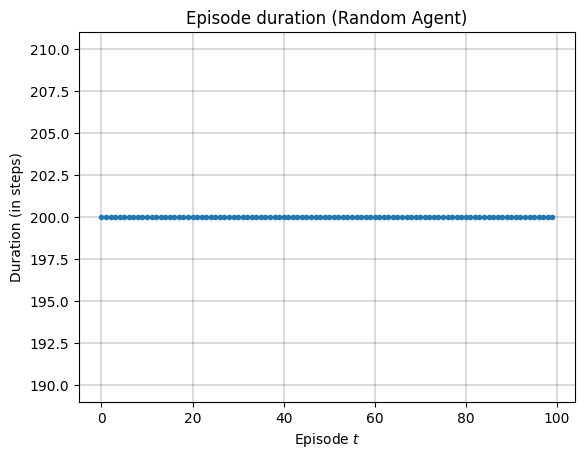

In [7]:
random_Agent.env=gym.make('MountainCar-v0')
episodesHistory = random_Agent.play(episodes = 100,seed = False)

fig1,ax1 = plt.subplots(1,1)
ax1.plot(range(episodesHistory.shape[0]), np.abs(episodesHistory), marker='.')
ax1.set_title(f'Episode duration (Random Agent)')
ax1.set_xlabel(r'Episode $t$')
ax1.set_ylabel('Duration (in steps)')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/EpDurationRA_ep{episodesHistory.shape[0]}.png', format='png')
    

In [ ]:
'''
DQN
'''

100%|██████████| 1000/1000 [12:51<00:00,  1.30it/s]


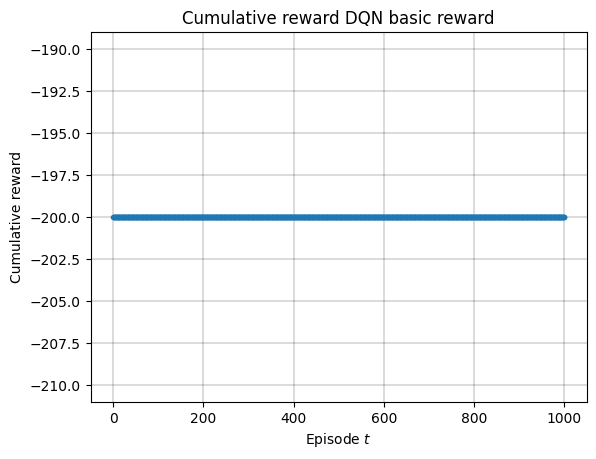

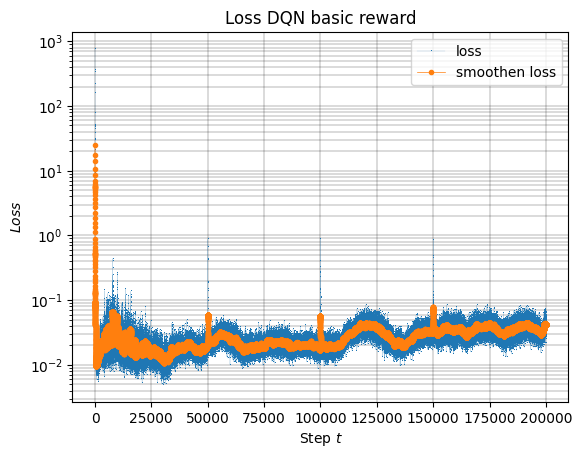

In [41]:
episodes = 1000
batch_size = 64
refreshQTarget = 50000
reset_init = 1
replay_buffer_SIZE = 10000
epsilonDecreasing = 100
reward_factor = 0
predList_batch_size = 0
firstUpdate = 0
NewPosReward = np.array([None])

DQN = DQNAgent("id0",epsilonMax = 1, predList_batch_size = predList_batch_size, reward_factor = reward_factor, batch_size = batch_size, arrayNewPosReward = NewPosReward, replay_buffer_SIZE = replay_buffer_SIZE)
episodesHistory, _, lossHistory, _, _,_,_,_ = DQN.train(episodes, refreshQTarget = refreshQTarget, firstUpdate = firstUpdate, recap_mode=False, reset_init = reset_init, epsilonDecreasing =epsilonDecreasing)

fig1,ax1 = plt.subplots(1,1)
ax1.plot(range(episodesHistory.shape[0]), episodesHistory, marker='.')
ax1.set_title(f'Cumulative reward DQN basic reward')
ax1.set_xlabel(r'Episode $t$')
ax1.set_ylabel('Cumulative reward')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeRewardDQNbasicR_ep{episodes}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

window= 100
average_dataL = []
for i in range(len(lossHistory) - window + 1):
    average_dataL.append(np.mean(lossHistory[i:i+window]))
fig3,ax3 = plt.subplots(1,1)
ax3.plot(range(lossHistory.shape[0]), lossHistory, marker=',', linewidth =0.1, label="loss")
ax3.plot(range(len(average_dataL)), average_dataL, marker='.', linewidth =0.5, label="smoothen loss")
ax3.set_title(f'Loss DQN basic reward')
ax3.set_xlabel(r'Step $t$')
ax3.set_ylabel(r'$Loss$')
ax3.set_xscale('linear')
ax3.set_yscale('log')
ax3.legend()
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/LossDQNbasicR_ep{episodes}_u{u}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')


In [ ]:
'''
DQN HEURISTIC REWARD
'''

100%|██████████| 3000/3000 [38:47<00:00,  1.29it/s]


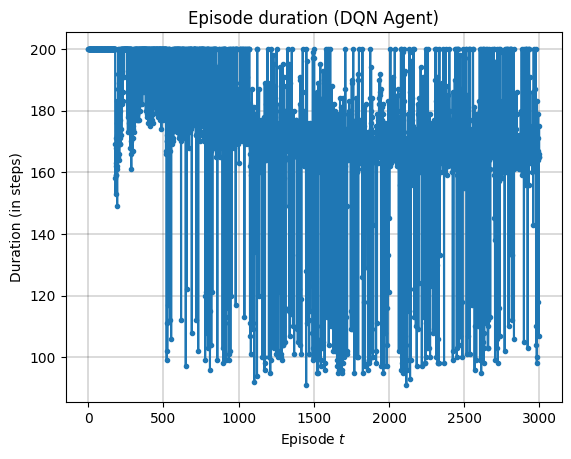

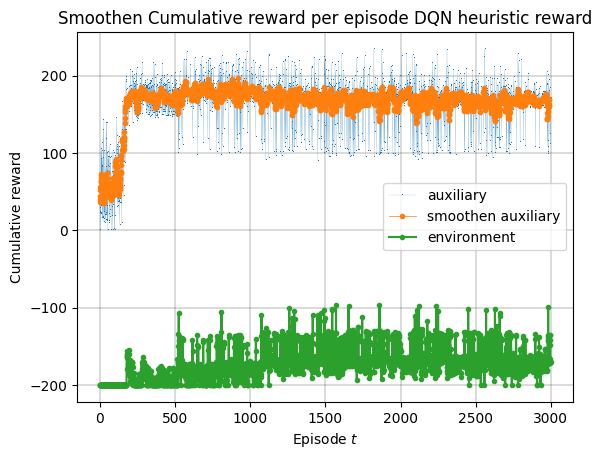

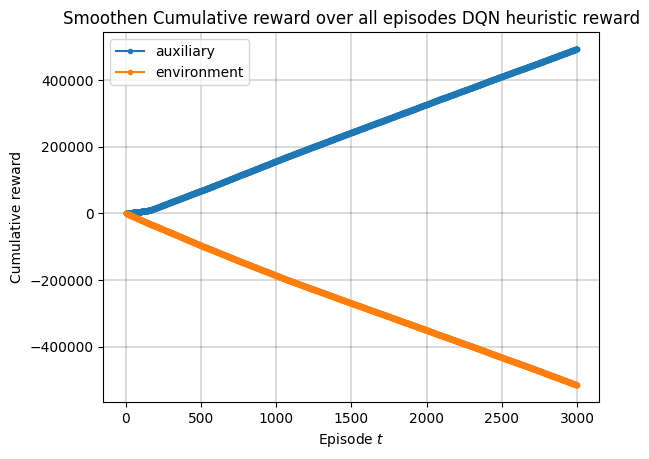

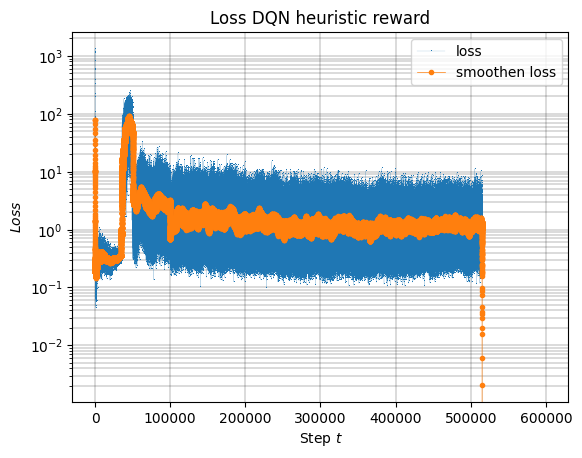

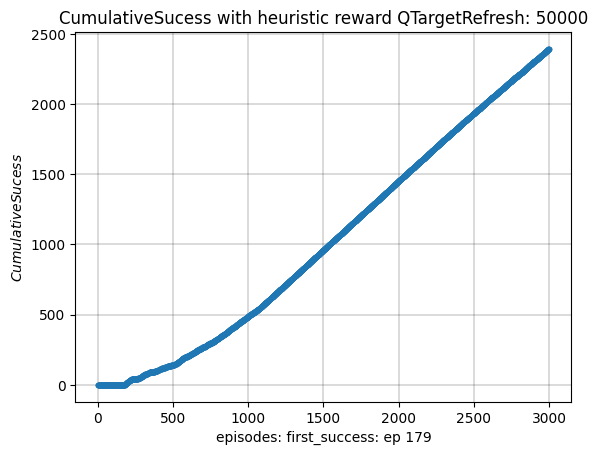

In [44]:
episodes = 3000
batch_size = 64
refreshQTarget = 50000
reset_init = 1
replay_buffer_SIZE = 10000
epsilonDecreasing = 100
reward_factor = 0
predList_batch_size = 0
firstUpdate = 0
u=0.05
NewPosReward = np.array([(-1.1,u*7),(-1,u*6),(-0.9,u*5),(-0.8,u*4),(-0.7,u*3),(-0.6,u*2),(-0.4,u*2),(-0.3,u*3),(-0.2,u*4),(-0.1,u*5),(0,u*6),(0.1,u*7),(0.2,u*8),(0.3,u*9),(0.4,u*10),(0.5,20*u)])

DQN = DQNAgent("id0",epsilonMax = 1, predList_batch_size = predList_batch_size, reward_factor = reward_factor, batch_size = batch_size, arrayNewPosReward = NewPosReward, replay_buffer_SIZE = replay_buffer_SIZE)
episodesHistory, _, lossHistory, _,cumulativeHistory, durationHistory,_,_ = DQN.train(episodes, refreshQTarget = refreshQTarget, firstUpdate = firstUpdate, recap_mode = False, debug_mode = False, reset_init = reset_init, epsilonDecreasing =epsilonDecreasing)

fig1b,ax1b = plt.subplots(1,1)
ax1b.plot(range(durationHistory.shape[0]), durationHistory, marker='.')
ax1b.set_title(f'Episode duration (DQN Agent)')
ax1b.set_xlabel(r'Episode $t$')
ax1b.set_ylabel('Duration (in steps)')
ax1b.set_xscale('linear')
ax1b.set_yscale('linear')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/EpDurationDQN_ep{durationHistory.shape[0]}_u{u}.png', format='png')

window = 10
average_data = []
for i in range(len(episodesHistory) - window + 1):
    average_data.append(np.mean(episodesHistory[i:i+window]+durationHistory[i:i+window]))

fig1,ax1 = plt.subplots(1,1)
ax1.plot(range(len(episodesHistory)), episodesHistory+durationHistory, marker=',',linewidth = 0.1, label="auxiliary")
ax1.plot(range(len(average_data)), average_data, marker='.',linewidth = 0.5, label="smoothen auxiliary")
average_data2 = []
window=2
for i in range(len(episodesHistory) - window + 1):
    average_data2.append(np.mean(-durationHistory[i:i+window]))
ax1.plot(range(len(average_data2)), average_data2, marker='.', label="environment")

average_data5 = []
for i in range(len(episodesHistory) - window + 1):
    average_data5.append(np.mean(episodesHistory[i:i+window]))
#ax1.plot(range(len(average_data5)), average_data5, marker='.', label="both")
ax1.set_title(f'Smoothen Cumulative reward per episode DQN heuristic reward')
ax1.set_xlabel(r'Episode $t$')
ax1.set_ylabel('Cumulative reward')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.legend()
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeRewardPerDQNheurR_ep{episodes}_u{u}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

window = 1
sumReward = [episodesHistory[0]+durationHistory[0]]
for i in range(len(episodesHistory)-1):
    sumReward.append(episodesHistory[i+1]+durationHistory[i+1]+sumReward[i])
average_data3 = []
for i in range(len(sumReward) - window + 1):
    average_data3.append(np.mean(sumReward[i:i+window]))

fig1c,ax1c = plt.subplots(1,1)
ax1c.plot(range(len(average_data3)), average_data3, marker='.', label="auxiliary")

sumReward2 = [durationHistory[0]]
for i in range(len(episodesHistory)-1):
    sumReward2.append(-durationHistory[i+1]+sumReward2[i])
average_data4 = []
for i in range(len(sumReward2) - window + 1):
    average_data4.append(np.mean(sumReward2[i:i+window]))
ax1c.plot(range(len(average_data4)), average_data4, marker='.', label="environment")

sumReward3 = [episodesHistory[0]]
for i in range(len(episodesHistory)-1):
    sumReward3.append(episodesHistory[i+1]+sumReward2[i])
average_data6 = []
for i in range(len(sumReward3) - window + 1):
    average_data6.append(np.mean(sumReward3[i:i+window]))
#ax1c.plot(range(len(average_data6)), average_data6, marker='.', label="both")
ax1c.set_title(f'Smoothen Cumulative reward over all episodes DQN heuristic reward')
ax1c.set_xlabel(r'Episode $t$')
ax1c.set_ylabel('Cumulative reward')
ax1c.set_xscale('linear')
ax1c.set_yscale('linear')
ax1c.legend()
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeRewardOverDQNheurR_ep{episodes}_u{u}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

window= 100
average_dataL = []
for i in range(len(lossHistory) - window + 1):
    average_dataL.append(np.mean(lossHistory[i:i+window]))
fig3,ax3 = plt.subplots(1,1)
ax3.plot(range(lossHistory.shape[0]), lossHistory, marker=',', linewidth =0.1, label="loss")
ax3.plot(range(len(average_dataL)), average_dataL, marker='.', linewidth =0.5, label="smoothen loss")
ax3.set_title(f'Loss DQN heuristic reward')
ax3.set_xlabel(r'Step $t$')
ax3.set_ylabel(r'$Loss$')
ax3.set_xscale('linear')
ax3.set_yscale('log')
ax3.legend()
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/LossDQNheurR_ep{episodes}_u{u}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

s=0
for e in range(cumulativeHistory.shape[0]):
    if cumulativeHistory[e] == 1:
        s = e
        break
fig5,ax5 = plt.subplots(1,1)
ax5.plot(range(cumulativeHistory.shape[0]), cumulativeHistory[:], marker='.')
ax5.set_title(f'Cumulative Sucess DQN heuristic reward')
if u>0: ax5.set_title(f'CumulativeSucess with heuristic reward QTargetRefresh: {refreshQTarget}')
if reward_factor>0:ax5.set_title(f'CumulativeSucess with RND RewardFactor: {reward_factor} QTargetRefresh: {refreshQTarget}')
ax5.set_xlabel(r'episodes: first_success: ep '+str(s))
ax5.set_ylabel(r'$CumulativeSucess$')
ax5.set_xscale('linear')
ax5.set_yscale('linear')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeSucessDQNheurR_ep{episodes}_u{u}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')


100%|██████████| 600/600 [10:01<00:00,  1.00s/it]


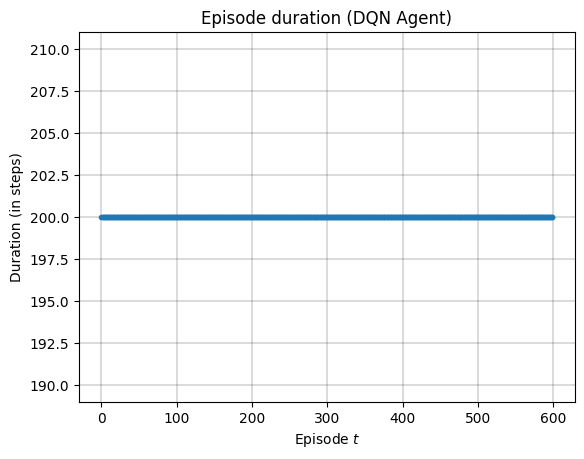

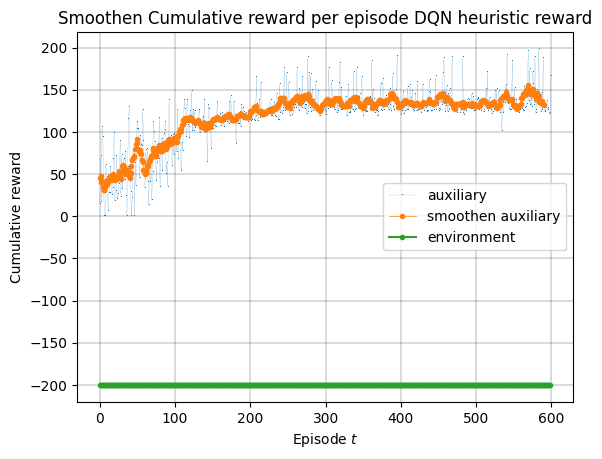

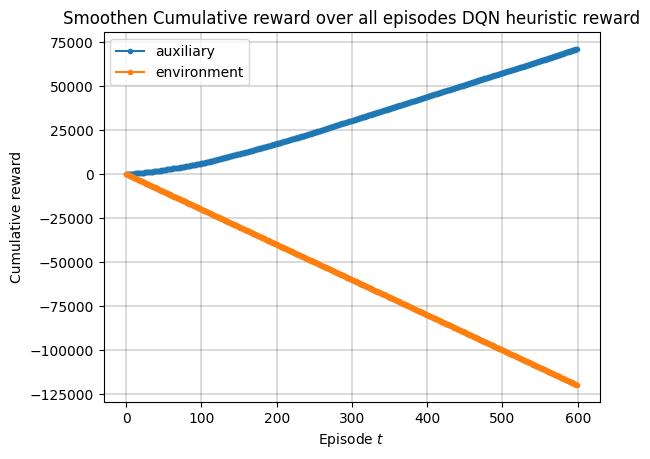

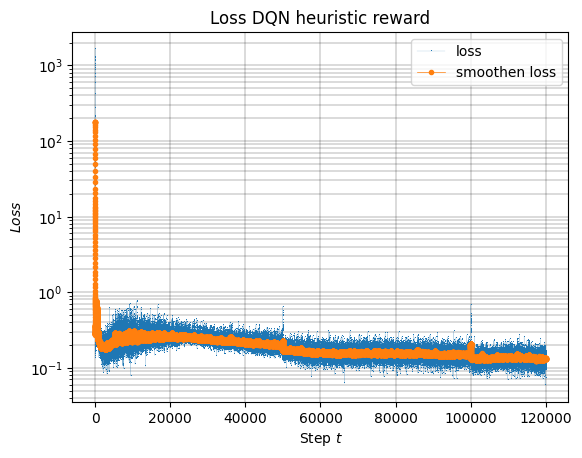

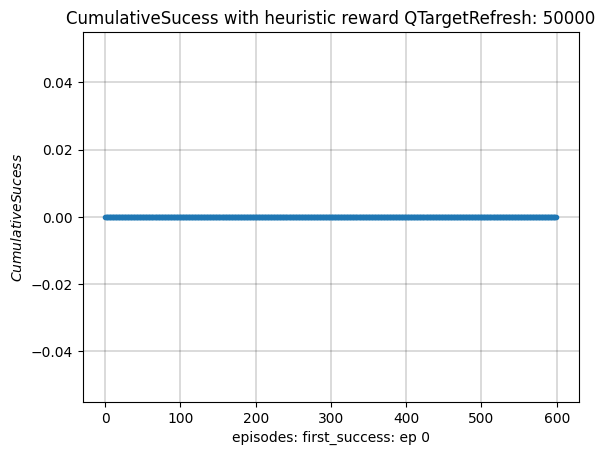

In [45]:
episodes = 600
batch_size = 64
refreshQTarget = 50000
reset_init = 1
replay_buffer_SIZE = 10000
epsilonDecreasing = 100
reward_factor = 0
predList_batch_size = 0
firstUpdate = 0
u=0.001
NewPosReward = np.array([(-1.1,u*7),(-1,u*6),(-0.9,u*5),(-0.8,u*4),(-0.7,u*3),(-0.6,u*2),(-0.4,u*2),(-0.3,u*3),(-0.2,u*4),(-0.1,u*5),(0,u*6),(0.1,u*7),(0.2,u*8),(0.3,u*9),(0.4,u*10),(0.5,20*u)])

DQN = DQNAgent("id0",epsilonMax = 1, predList_batch_size = predList_batch_size, reward_factor = reward_factor, batch_size = batch_size, arrayNewPosReward = NewPosReward, replay_buffer_SIZE = replay_buffer_SIZE)
episodesHistory, _, lossHistory, _,cumulativeHistory,durationHistory,_,_ = DQN.train(episodes, refreshQTarget = refreshQTarget, firstUpdate = firstUpdate, recap_mode = False, debug_mode = False, reset_init = reset_init, epsilonDecreasing =epsilonDecreasing)

fig1b,ax1b = plt.subplots(1,1)
ax1b.plot(range(durationHistory.shape[0]), durationHistory, marker='.')
ax1b.set_title(f'Episode duration (DQN Agent)')
ax1b.set_xlabel(r'Episode $t$')
ax1b.set_ylabel('Duration (in steps)')
ax1b.set_xscale('linear')
ax1b.set_yscale('linear')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/EpDurationRA_ep{durationHistory.shape[0]}_u{u}.png', format='png')

window = 10
average_data = []
for i in range(len(episodesHistory) - window + 1):
    average_data.append(np.mean(episodesHistory[i:i+window]+durationHistory[i:i+window]))

fig1,ax1 = plt.subplots(1,1)
ax1.plot(range(len(episodesHistory)), episodesHistory+durationHistory, marker=',',linewidth = 0.1, label="auxiliary")
ax1.plot(range(len(average_data)), average_data, marker='.',linewidth = 0.5, label="smoothen auxiliary")
average_data2 = []
window=2
for i in range(len(episodesHistory) - window + 1):
    average_data2.append(np.mean(-durationHistory[i:i+window]))
ax1.plot(range(len(average_data2)), average_data2, marker='.', label="environment")

average_data5 = []
for i in range(len(episodesHistory) - window + 1):
    average_data5.append(np.mean(episodesHistory[i:i+window]))
#ax1.plot(range(len(average_data5)), average_data5, marker='.', label="both")
ax1.set_title(f'Smoothen Cumulative reward per episode DQN heuristic reward')
ax1.set_xlabel(r'Episode $t$')
ax1.set_ylabel('Cumulative reward')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.legend()
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeRewardPerDQNheurR_ep{episodes}_u{u}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

window = 1
sumReward = [episodesHistory[0]+durationHistory[0]]
for i in range(len(episodesHistory)-1):
    sumReward.append(episodesHistory[i+1]+durationHistory[i+1]+sumReward[i])
average_data3 = []
for i in range(len(sumReward) - window + 1):
    average_data3.append(np.mean(sumReward[i:i+window]))

fig1c,ax1c = plt.subplots(1,1)
ax1c.plot(range(len(average_data3)), average_data3, marker='.', label="auxiliary")

sumReward2 = [durationHistory[0]]
for i in range(len(episodesHistory)-1):
    sumReward2.append(-durationHistory[i+1]+sumReward2[i])
average_data4 = []
for i in range(len(sumReward2) - window + 1):
    average_data4.append(np.mean(sumReward2[i:i+window]))
ax1c.plot(range(len(average_data4)), average_data4, marker='.', label="environment")

sumReward3 = [episodesHistory[0]]
for i in range(len(episodesHistory)-1):
    sumReward3.append(episodesHistory[i+1]+sumReward2[i])
average_data6 = []
for i in range(len(sumReward3) - window + 1):
    average_data6.append(np.mean(sumReward3[i:i+window]))
#ax1c.plot(range(len(average_data6)), average_data6, marker='.', label="both")
ax1c.set_title(f'Smoothen Cumulative reward over all episodes DQN heuristic reward')
ax1c.set_xlabel(r'Episode $t$')
ax1c.set_ylabel('Cumulative reward')
ax1c.set_xscale('linear')
ax1c.set_yscale('linear')
ax1c.legend()
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeRewardOverDQNheurR_ep{episodes}_u{u}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

window= 100
average_dataL = []
for i in range(len(lossHistory) - window + 1):
    average_dataL.append(np.mean(lossHistory[i:i+window]))
fig3,ax3 = plt.subplots(1,1)
ax3.plot(range(lossHistory.shape[0]), lossHistory, marker=',', linewidth =0.1, label="loss")
ax3.plot(range(len(average_dataL)), average_dataL, marker='.', linewidth =0.5, label="smoothen loss")
ax3.set_title(f'Loss DQN heuristic reward')
ax3.set_xlabel(r'Step $t$')
ax3.set_ylabel(r'$Loss$')
ax3.set_xscale('linear')
ax3.set_yscale('log')
ax3.legend()
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/LossDQNheurR_ep{episodes}_u{u}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

s=0
for e in range(cumulativeHistory.shape[0]):
    if cumulativeHistory[e] == 1:
        s = e
        break
fig5,ax5 = plt.subplots(1,1)
ax5.plot(range(cumulativeHistory.shape[0]), cumulativeHistory[:], marker='.')
ax5.set_title(f'Cumulative Sucess DQN heuristic reward')
if u>0: ax5.set_title(f'CumulativeSucess with heuristic reward QTargetRefresh: {refreshQTarget}')
if reward_factor>0:ax5.set_title(f'CumulativeSucess with RND RewardFactor: {reward_factor} QTargetRefresh: {refreshQTarget}')
ax5.set_xlabel(r'episodes: first_success: ep '+str(s))
ax5.set_ylabel(r'$CumulativeSucess$')
ax5.set_xscale('linear')
ax5.set_yscale('linear')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeSucessDQNheurR_ep{episodes}_u{u}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')


100%|██████████| 600/600 [09:23<00:00,  1.06it/s]


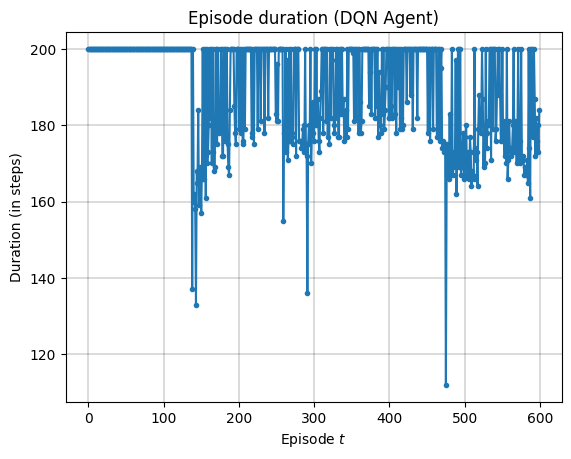

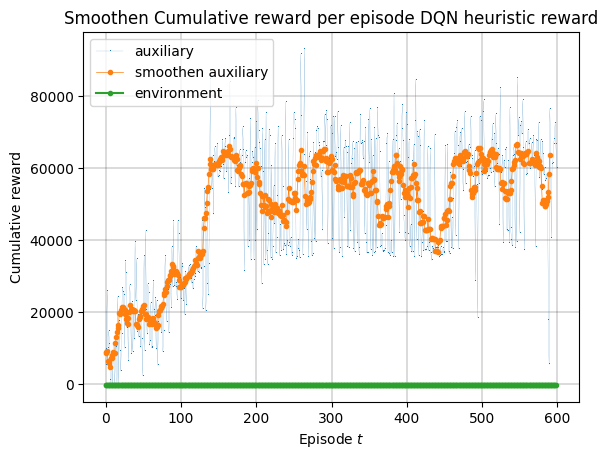

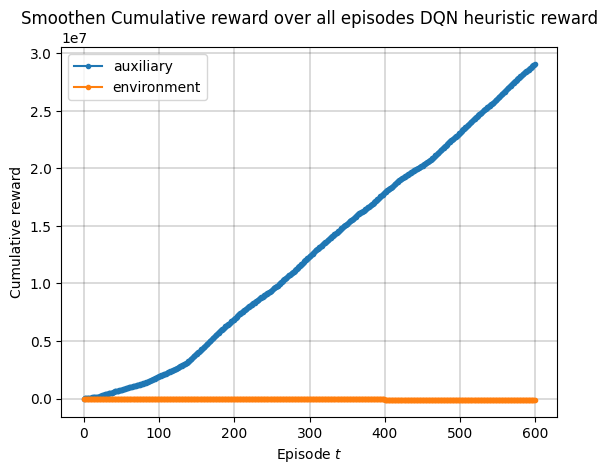

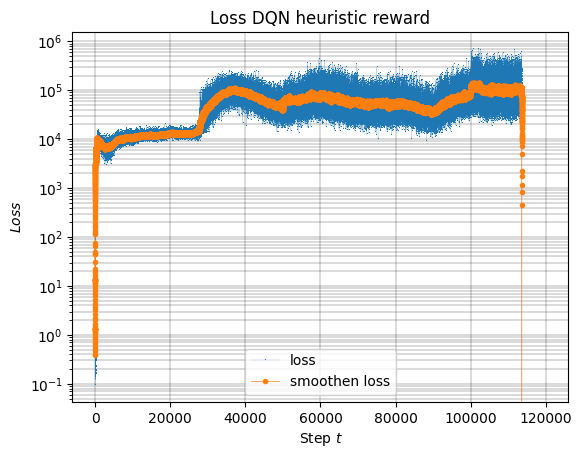

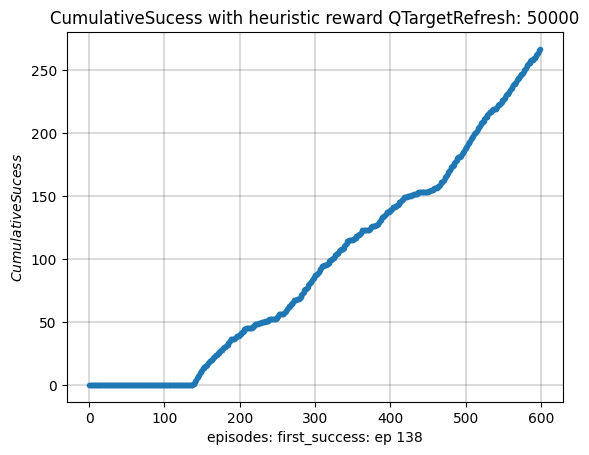

In [46]:
episodes = 600
batch_size = 64
refreshQTarget = 50000
reset_init = 1
replay_buffer_SIZE = 10000
epsilonDecreasing = 100
reward_factor = 0
predList_batch_size = 0
firstUpdate = 0
u=100
NewPosReward = np.array([(-1.1,u*7),(-1,u*6),(-0.9,u*5),(-0.8,u*4),(-0.7,u*3),(-0.6,u*2),(-0.4,u*2),(-0.3,u*3),(-0.2,u*4),(-0.1,u*5),(0,u*6),(0.1,u*7),(0.2,u*8),(0.3,u*9),(0.4,u*10),(0.5,20*u)])

DQN = DQNAgent("id0",epsilonMax = 1, predList_batch_size = predList_batch_size, reward_factor = reward_factor, batch_size = batch_size, arrayNewPosReward = NewPosReward, replay_buffer_SIZE = replay_buffer_SIZE)
episodesHistory, _, lossHistory, _,cumulativeHistory,durationHistory,_,_ = DQN.train(episodes, refreshQTarget = refreshQTarget, firstUpdate = firstUpdate, recap_mode = False, debug_mode = False, reset_init = reset_init, epsilonDecreasing =epsilonDecreasing)

fig1b,ax1b = plt.subplots(1,1)
ax1b.plot(range(durationHistory.shape[0]), durationHistory, marker='.')
ax1b.set_title(f'Episode duration (DQN Agent)')
ax1b.set_xlabel(r'Episode $t$')
ax1b.set_ylabel('Duration (in steps)')
ax1b.set_xscale('linear')
ax1b.set_yscale('linear')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/EpDurationRA_ep{durationHistory.shape[0]}_u{u}.png', format='png')

window = 10
average_data = []
for i in range(len(episodesHistory) - window + 1):
    average_data.append(np.mean(episodesHistory[i:i+window]+durationHistory[i:i+window]))

fig1,ax1 = plt.subplots(1,1)
ax1.plot(range(len(episodesHistory)), episodesHistory+durationHistory, marker=',',linewidth = 0.1, label="auxiliary")
ax1.plot(range(len(average_data)), average_data, marker='.',linewidth = 0.5, label="smoothen auxiliary")
average_data2 = []
window=2
for i in range(len(episodesHistory) - window + 1):
    average_data2.append(np.mean(-durationHistory[i:i+window]))
ax1.plot(range(len(average_data2)), average_data2, marker='.', label="environment")

average_data5 = []
for i in range(len(episodesHistory) - window + 1):
    average_data5.append(np.mean(episodesHistory[i:i+window]))
#ax1.plot(range(len(average_data5)), average_data5, marker='.', label="both")
ax1.set_title(f'Smoothen Cumulative reward per episode DQN heuristic reward')
ax1.set_xlabel(r'Episode $t$')
ax1.set_ylabel('Cumulative reward')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.legend()
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeRewardPerDQNheurR_ep{episodes}_u{u}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

window = 1
sumReward = [episodesHistory[0]+durationHistory[0]]
for i in range(len(episodesHistory)-1):
    sumReward.append(episodesHistory[i+1]+durationHistory[i+1]+sumReward[i])
average_data3 = []
for i in range(len(sumReward) - window + 1):
    average_data3.append(np.mean(sumReward[i:i+window]))

fig1c,ax1c = plt.subplots(1,1)
ax1c.plot(range(len(average_data3)), average_data3, marker='.', label="auxiliary")

sumReward2 = [durationHistory[0]]
for i in range(len(episodesHistory)-1):
    sumReward2.append(-durationHistory[i+1]+sumReward2[i])
average_data4 = []
for i in range(len(sumReward2) - window + 1):
    average_data4.append(np.mean(sumReward2[i:i+window]))
ax1c.plot(range(len(average_data4)), average_data4, marker='.', label="environment")

sumReward3 = [episodesHistory[0]]
for i in range(len(episodesHistory)-1):
    sumReward3.append(episodesHistory[i+1]+sumReward2[i])
average_data6 = []
for i in range(len(sumReward3) - window + 1):
    average_data6.append(np.mean(sumReward3[i:i+window]))
#ax1c.plot(range(len(average_data6)), average_data6, marker='.', label="both")
ax1c.set_title(f'Smoothen Cumulative reward over all episodes DQN heuristic reward')
ax1c.set_xlabel(r'Episode $t$')
ax1c.set_ylabel('Cumulative reward')
ax1c.set_xscale('linear')
ax1c.set_yscale('linear')
ax1c.legend()
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeRewardOverDQNheurR_ep{episodes}_u{u}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

window= 100
average_dataL = []
for i in range(len(lossHistory) - window + 1):
    average_dataL.append(np.mean(lossHistory[i:i+window]))
fig3,ax3 = plt.subplots(1,1)
ax3.plot(range(lossHistory.shape[0]), lossHistory, marker=',', linewidth =0.1, label="loss")
ax3.plot(range(len(average_dataL)), average_dataL, marker='.', linewidth =0.5, label="smoothen loss")
ax3.set_title(f'Loss DQN heuristic reward')
ax3.set_xlabel(r'Step $t$')
ax3.set_ylabel(r'$Loss$')
ax3.set_xscale('linear')
ax3.set_yscale('log')
ax3.legend()
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/LossDQNheurR_ep{episodes}_u{u}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

s=0
for e in range(cumulativeHistory.shape[0]):
    if cumulativeHistory[e] == 1:
        s = e
        break
fig5,ax5 = plt.subplots(1,1)
ax5.plot(range(cumulativeHistory.shape[0]), cumulativeHistory[:], marker='.')
ax5.set_title(f'Cumulative Sucess DQN heuristic reward')
if u>0: ax5.set_title(f'CumulativeSucess with heuristic reward QTargetRefresh: {refreshQTarget}')
if reward_factor>0:ax5.set_title(f'CumulativeSucess with RND RewardFactor: {reward_factor} QTargetRefresh: {refreshQTarget}')
ax5.set_xlabel(r'episodes: first_success: ep '+str(s))
ax5.set_ylabel(r'$CumulativeSucess$')
ax5.set_xscale('linear')
ax5.set_yscale('linear')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeSucessDQNheurR_ep{episodes}_u{u}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')


In [47]:
'''
DQN RND REWARD
'''

'\nDQN RND REWARD\n'

100%|██████████| 3000/3000 [52:16<00:00,  1.05s/it] 


NameError: name 'u' is not defined

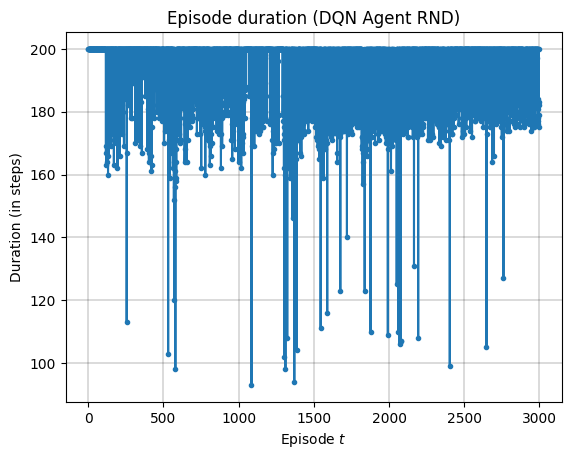

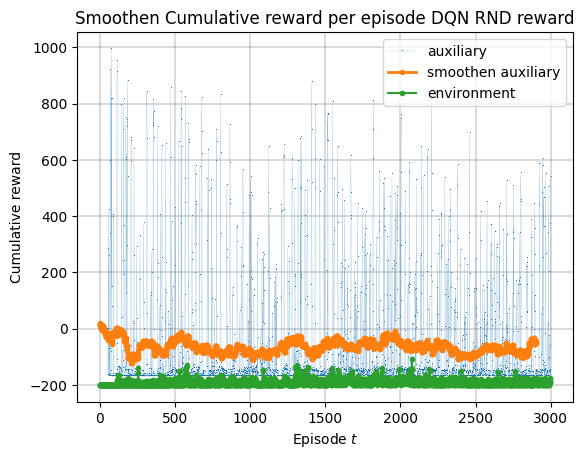

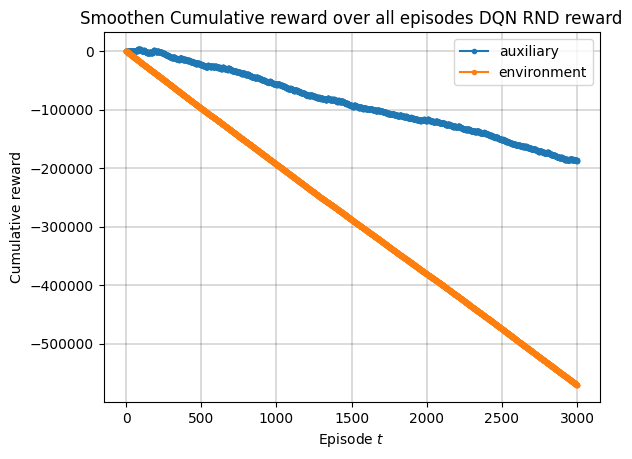

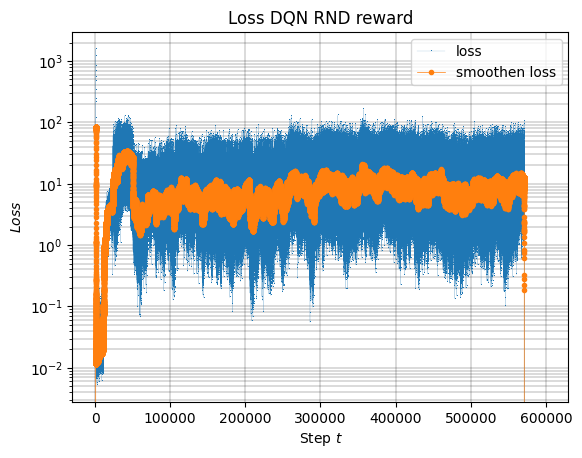

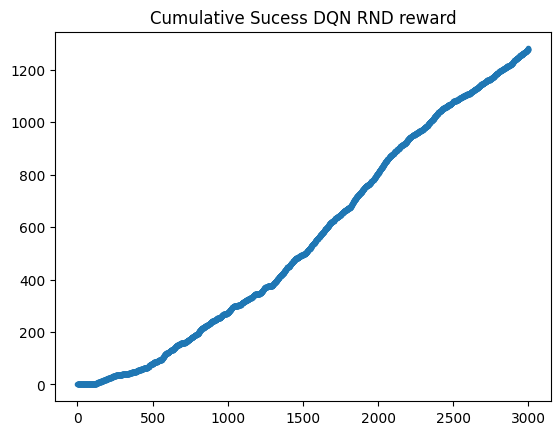

In [8]:
episodes = 3000
batch_size = 64
refreshQTarget = 50000
reset_init = 1
replay_buffer_SIZE = 10000
epsilonDecreasing = 100
reward_factor = 2
predList_batch_size = 10000
firstUpdate = 1000
NewPosReward = np.array([None])

DQN = DQNAgent("id0",epsilonMax = 1, predList_batch_size = predList_batch_size, reward_factor = reward_factor, batch_size = batch_size, arrayNewPosReward = NewPosReward, replay_buffer_SIZE = replay_buffer_SIZE)
episodesHistory, _, lossHistory, _,cumulativeHistory,durationHistory,_,_ = DQN.train(episodes, refreshQTarget = refreshQTarget, firstUpdate = firstUpdate, recap_mode=False, reset_init = reset_init, epsilonDecreasing =epsilonDecreasing)

fig1b,ax1b = plt.subplots(1,1)
ax1b.plot(range(durationHistory.shape[0]), durationHistory, marker='.')
ax1b.set_title(f'Episode duration (DQN Agent RND)')
ax1b.set_xlabel(r'Episode $t$')
ax1b.set_ylabel('Duration (in steps)')
ax1b.set_xscale('linear')
ax1b.set_yscale('linear')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/EpDurationRDN_ep{durationHistory.shape[0]}_rf{reward_factor}.png', format='png')

window = 100
average_data = []
for i in range(len(episodesHistory) - window + 1):
    average_data.append(np.mean(episodesHistory[i:i+window]+durationHistory[i:i+window]))

fig1,ax1 = plt.subplots(1,1)
ax1.plot(range(len(episodesHistory)), episodesHistory+durationHistory, marker=',',linewidth = 0.1, label="auxiliary")
ax1.plot(range(len(average_data)), average_data, marker='.',linewidth = 2, label="smoothen auxiliary")
average_data2 = []
window=2
for i in range(len(episodesHistory) - window + 1):
    average_data2.append(np.mean(-durationHistory[i:i+window]))
ax1.plot(range(len(average_data2)), average_data2, marker='.', label="environment")

average_data5 = []
for i in range(len(episodesHistory) - window + 1):
    average_data5.append(np.mean(episodesHistory[i:i+window]))
#ax1.plot(range(len(average_data5)), average_data5, marker='.', label="both")
ax1.set_title(f'Smoothen Cumulative reward per episode DQN RND reward')
ax1.set_xlabel(r'Episode $t$')
ax1.set_ylabel('Cumulative reward')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.legend()
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeRewardPerDQNrndR_ep{episodes}_rf{reward_factor}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

window = 1
sumReward = [episodesHistory[0]+durationHistory[0]]
for i in range(len(episodesHistory)-1):
    sumReward.append(episodesHistory[i+1]+durationHistory[i+1]+sumReward[i])
average_data3 = []
for i in range(len(sumReward) - window + 1):
    average_data3.append(np.mean(sumReward[i:i+window]))

fig1c,ax1c = plt.subplots(1,1)
ax1c.plot(range(len(average_data3)), average_data3, marker='.', label="auxiliary")

sumReward2 = [durationHistory[0]]
for i in range(len(episodesHistory)-1):
    sumReward2.append(-durationHistory[i+1]+sumReward2[i])
average_data4 = []
for i in range(len(sumReward2) - window + 1):
    average_data4.append(np.mean(sumReward2[i:i+window]))
ax1c.plot(range(len(average_data4)), average_data4, marker='.', label="environment")

sumReward3 = [episodesHistory[0]]
for i in range(len(episodesHistory)-1):
    sumReward3.append(episodesHistory[i+1]+sumReward2[i])
average_data6 = []
for i in range(len(sumReward3) - window + 1):
    average_data6.append(np.mean(sumReward3[i:i+window]))
#ax1c.plot(range(len(average_data6)), average_data6, marker='.', label="both")
ax1c.set_title(f'Smoothen Cumulative reward over all episodes DQN RND reward')
ax1c.set_xlabel(r'Episode $t$')
ax1c.set_ylabel('Cumulative reward')
ax1c.set_xscale('linear')
ax1c.set_yscale('linear')
ax1c.legend()
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeRewardOverDQNrndR_ep{episodes}_rf{reward_factor}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

window= 100
average_dataL = []
for i in range(len(lossHistory) - window + 1):
    average_dataL.append(np.mean(lossHistory[i:i+window]))
fig3,ax3 = plt.subplots(1,1)
ax3.plot(range(lossHistory.shape[0]), lossHistory, marker=',', linewidth =0.1, label="loss")
ax3.plot(range(len(average_dataL)), average_dataL, marker='.', linewidth =0.5, label="smoothen loss")
ax3.set_title(f'Loss DQN RND reward')
ax3.set_xlabel(r'Step $t$')
ax3.set_ylabel(r'$Loss$')
ax3.set_xscale('linear')
ax3.set_yscale('log')
ax3.legend()
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/LossDQNrndR_ep{episodes}_rf{reward_factor}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

s=0
for e in range(cumulativeHistory.shape[0]):
    if cumulativeHistory[e] == 1:
        s = e
        break
fig5,ax5 = plt.subplots(1,1)
ax5.plot(range(cumulativeHistory.shape[0]), cumulativeHistory[:], marker='.')
ax5.set_title(f'Cumulative Sucess DQN RND reward')
if u>0: ax5.set_title(f'CumulativeSucess with heuristic reward QTargetRefresh: {refreshQTarget}')
if reward_factor>0:ax5.set_title(f'CumulativeSucess with RND RewardFactor: {reward_factor} QTargetRefresh: {refreshQTarget}')
ax5.set_xlabel(r'episodes: first_success: ep '+str(s))
ax5.set_ylabel(r'$CumulativeSucess$')
ax5.set_xscale('linear')
ax5.set_yscale('linear')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeSucessDQNrndR_ep{episodes}_rf{reward_factor}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')


100%|██████████| 2000/2000 [36:12<00:00,  1.09s/it]


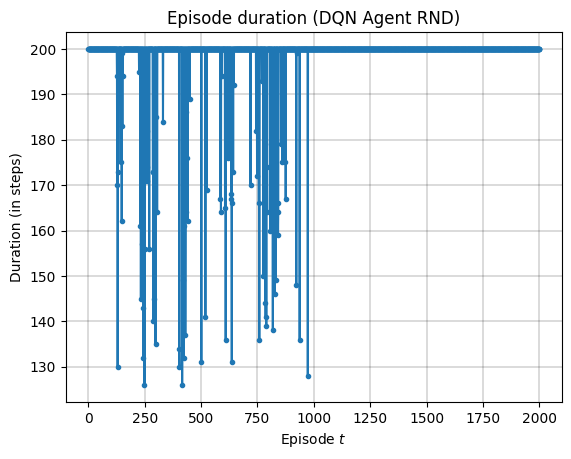

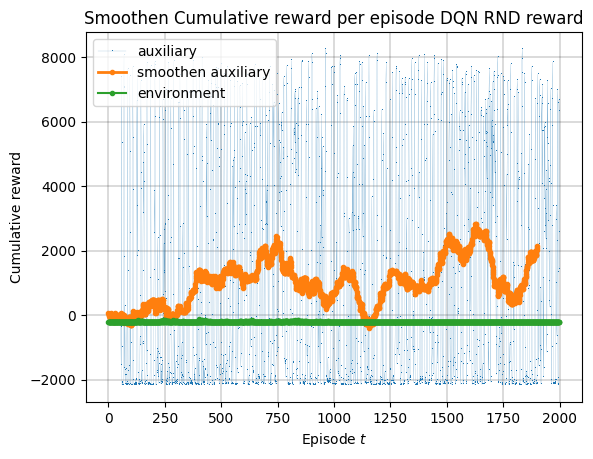

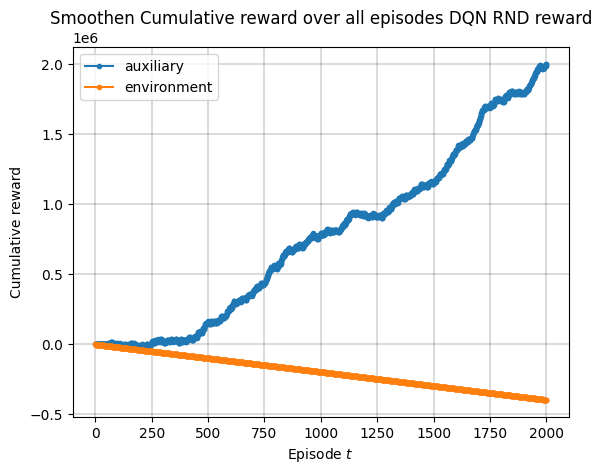

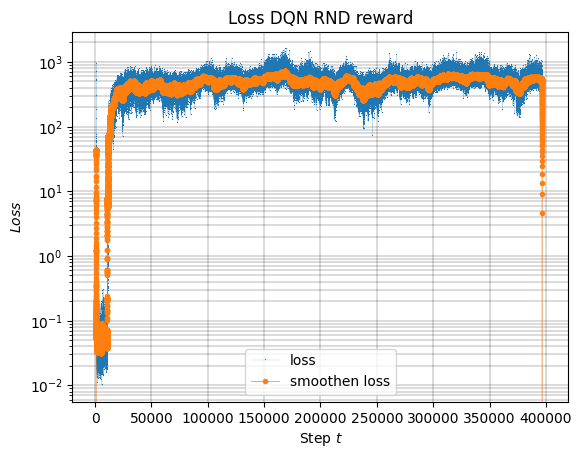

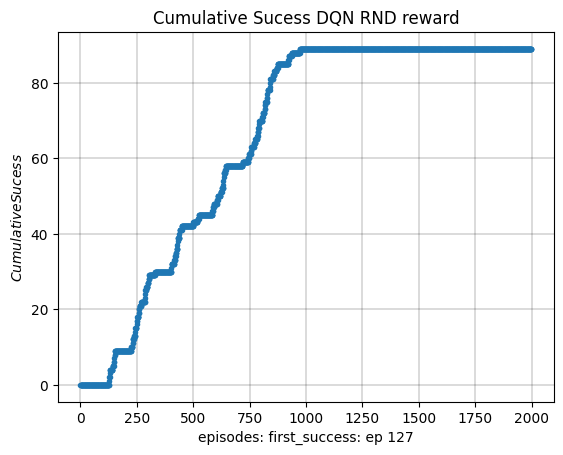

In [9]:
episodes = 2000
batch_size = 64
refreshQTarget = 50000
reset_init = 1
replay_buffer_SIZE = 10000
epsilonDecreasing = 100
reward_factor = 20
predList_batch_size = 10000
firstUpdate = 1000
NewPosReward = np.array([None])

DQN = DQNAgent("id0",epsilonMax = 1, predList_batch_size = predList_batch_size, reward_factor = reward_factor, batch_size = batch_size, arrayNewPosReward = NewPosReward, replay_buffer_SIZE = replay_buffer_SIZE)
episodesHistory, _, lossHistory, _,cumulativeHistory,durationHistory,_,_ = DQN.train(episodes, refreshQTarget = refreshQTarget, firstUpdate = firstUpdate, recap_mode=False, reset_init = reset_init, epsilonDecreasing =epsilonDecreasing)

fig1b,ax1b = plt.subplots(1,1)
ax1b.plot(range(durationHistory.shape[0]), durationHistory, marker='.')
ax1b.set_title(f'Episode duration (DQN Agent RND)')
ax1b.set_xlabel(r'Episode $t$')
ax1b.set_ylabel('Duration (in steps)')
ax1b.set_xscale('linear')
ax1b.set_yscale('linear')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/EpDurationRDN_ep{durationHistory.shape[0]}_rf{reward_factor}.png', format='png')

window = 100
average_data = []
for i in range(len(episodesHistory) - window + 1):
    average_data.append(np.mean(episodesHistory[i:i+window]+durationHistory[i:i+window]))

fig1,ax1 = plt.subplots(1,1)
ax1.plot(range(len(episodesHistory)), episodesHistory+durationHistory, marker=',',linewidth = 0.1, label="auxiliary")
ax1.plot(range(len(average_data)), average_data, marker='.',linewidth = 2, label="smoothen auxiliary")
average_data2 = []
window=2
for i in range(len(episodesHistory) - window + 1):
    average_data2.append(np.mean(-durationHistory[i:i+window]))
ax1.plot(range(len(average_data2)), average_data2, marker='.', label="environment")

average_data5 = []
for i in range(len(episodesHistory) - window + 1):
    average_data5.append(np.mean(episodesHistory[i:i+window]))
#ax1.plot(range(len(average_data5)), average_data5, marker='.', label="both")
ax1.set_title(f'Smoothen Cumulative reward per episode DQN RND reward')
ax1.set_xlabel(r'Episode $t$')
ax1.set_ylabel('Cumulative reward')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.legend()
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeRewardPerDQNrndR_ep{episodes}_rf{reward_factor}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

window = 1
sumReward = [episodesHistory[0]+durationHistory[0]]
for i in range(len(episodesHistory)-1):
    sumReward.append(episodesHistory[i+1]+durationHistory[i+1]+sumReward[i])
average_data3 = []
for i in range(len(sumReward) - window + 1):
    average_data3.append(np.mean(sumReward[i:i+window]))

fig1c,ax1c = plt.subplots(1,1)
ax1c.plot(range(len(average_data3)), average_data3, marker='.', label="auxiliary")

sumReward2 = [durationHistory[0]]
for i in range(len(episodesHistory)-1):
    sumReward2.append(-durationHistory[i+1]+sumReward2[i])
average_data4 = []
for i in range(len(sumReward2) - window + 1):
    average_data4.append(np.mean(sumReward2[i:i+window]))
ax1c.plot(range(len(average_data4)), average_data4, marker='.', label="environment")

sumReward3 = [episodesHistory[0]]
for i in range(len(episodesHistory)-1):
    sumReward3.append(episodesHistory[i+1]+sumReward2[i])
average_data6 = []
for i in range(len(sumReward3) - window + 1):
    average_data6.append(np.mean(sumReward3[i:i+window]))
#ax1c.plot(range(len(average_data6)), average_data6, marker='.', label="both")
ax1c.set_title(f'Smoothen Cumulative reward over all episodes DQN RND reward')
ax1c.set_xlabel(r'Episode $t$')
ax1c.set_ylabel('Cumulative reward')
ax1c.set_xscale('linear')
ax1c.set_yscale('linear')
ax1c.legend()
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeRewardOverDQNrndR_ep{episodes}_rf{reward_factor}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

window= 100
average_dataL = []
for i in range(len(lossHistory) - window + 1):
    average_dataL.append(np.mean(lossHistory[i:i+window]))
fig3,ax3 = plt.subplots(1,1)
ax3.plot(range(lossHistory.shape[0]), lossHistory, marker=',', linewidth =0.1, label="loss")
ax3.plot(range(len(average_dataL)), average_dataL, marker='.', linewidth =0.5, label="smoothen loss")
ax3.set_title(f'Loss DQN RND reward')
ax3.set_xlabel(r'Step $t$')
ax3.set_ylabel(r'$Loss$')
ax3.set_xscale('linear')
ax3.set_yscale('log')
ax3.legend()
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/LossDQNrndR_ep{episodes}_rf{reward_factor}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

s=0
for e in range(cumulativeHistory.shape[0]):
    if cumulativeHistory[e] == 1:
        s = e
        break
fig5,ax5 = plt.subplots(1,1)
ax5.plot(range(cumulativeHistory.shape[0]), cumulativeHistory[:], marker='.')
ax5.set_title(f'Cumulative Sucess DQN RND reward')
ax5.set_xlabel(r'episodes: first_success: ep '+str(s))
ax5.set_ylabel(r'$CumulativeSucess$')
ax5.set_xscale('linear')
ax5.set_yscale('linear')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeSucessDQNrndR_ep{episodes}_rf{reward_factor}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')


100%|██████████| 1000/1000 [19:23<00:00,  1.16s/it]


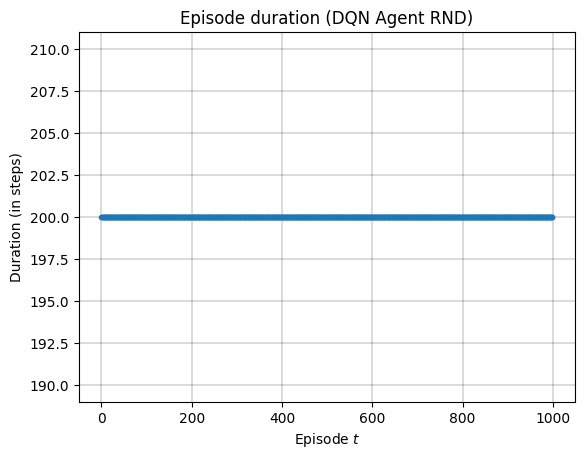

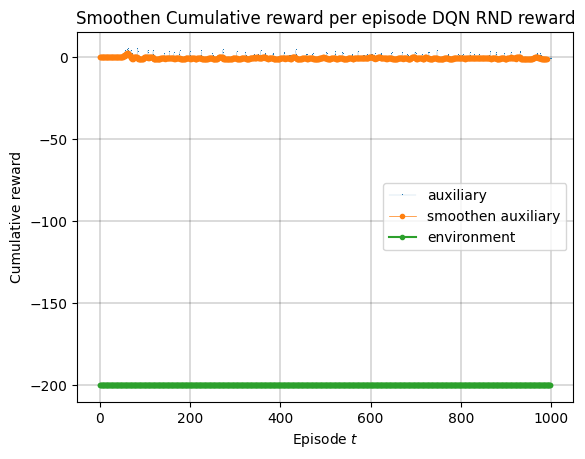

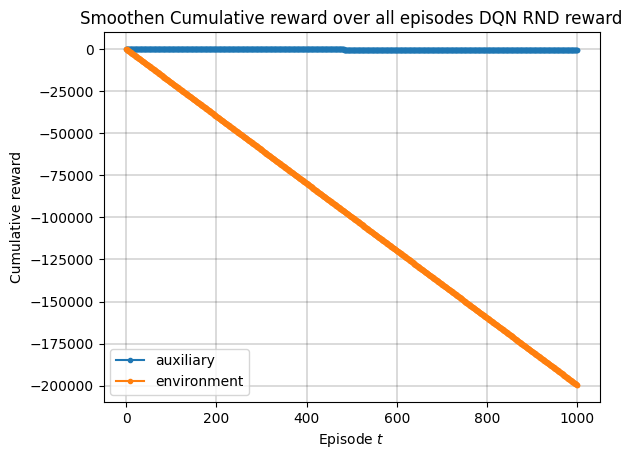

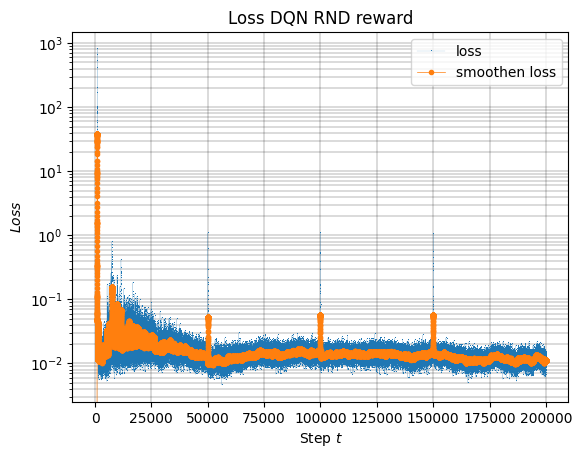

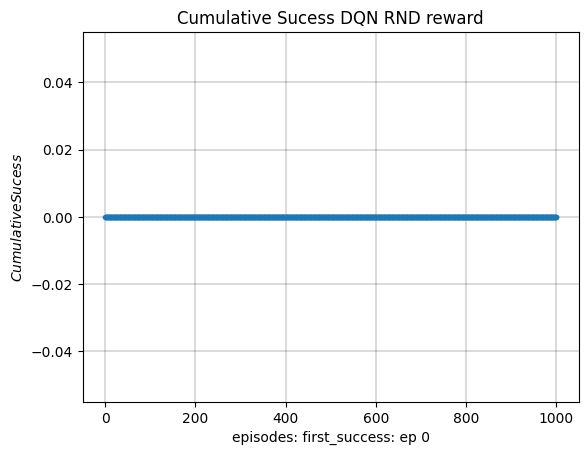

In [10]:
episodes = 1000
batch_size = 64
refreshQTarget = 50000
reset_init = 1
replay_buffer_SIZE = 10000
epsilonDecreasing = 100
reward_factor = 0.01
predList_batch_size = 10000
firstUpdate = 1000
NewPosReward = np.array([None])

DQN = DQNAgent("id0",epsilonMax = 1, predList_batch_size = predList_batch_size, reward_factor = reward_factor, batch_size = batch_size, arrayNewPosReward = NewPosReward, replay_buffer_SIZE = replay_buffer_SIZE)
episodesHistory, _, lossHistory, _,cumulativeHistory,durationHistory,_,_ = DQN.train(episodes, refreshQTarget = refreshQTarget, firstUpdate = firstUpdate, recap_mode=False, reset_init = reset_init, epsilonDecreasing =epsilonDecreasing)

fig1b,ax1b = plt.subplots(1,1)
ax1b.plot(range(durationHistory.shape[0]), durationHistory, marker='.')
ax1b.set_title(f'Episode duration (DQN Agent RND)')
ax1b.set_xlabel(r'Episode $t$')
ax1b.set_ylabel('Duration (in steps)')
ax1b.set_xscale('linear')
ax1b.set_yscale('linear')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/EpDurationRDN_ep{durationHistory.shape[0]}_rf{reward_factor}.png', format='png')

window = 10
average_data = []
for i in range(len(episodesHistory) - window + 1):
    average_data.append(np.mean(episodesHistory[i:i+window]+durationHistory[i:i+window]))

fig1,ax1 = plt.subplots(1,1)
ax1.plot(range(len(episodesHistory)), episodesHistory+durationHistory, marker=',',linewidth = 0.1, label="auxiliary")
ax1.plot(range(len(average_data)), average_data, marker='.',linewidth = 0.5, label="smoothen auxiliary")
average_data2 = []
window=2
for i in range(len(episodesHistory) - window + 1):
    average_data2.append(np.mean(-durationHistory[i:i+window]))
ax1.plot(range(len(average_data2)), average_data2, marker='.', label="environment")

average_data5 = []
for i in range(len(episodesHistory) - window + 1):
    average_data5.append(np.mean(episodesHistory[i:i+window]))
#ax1.plot(range(len(average_data5)), average_data5, marker='.', label="both")
ax1.set_title(f'Smoothen Cumulative reward per episode DQN RND reward')
ax1.set_xlabel(r'Episode $t$')
ax1.set_ylabel('Cumulative reward')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.legend()
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeRewardPerDQNrndR_ep{episodes}_rf{reward_factor}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

window = 1
sumReward = [episodesHistory[0]+durationHistory[0]]
for i in range(len(episodesHistory)-1):
    sumReward.append(episodesHistory[i+1]+durationHistory[i+1]+sumReward[i])
average_data3 = []
for i in range(len(sumReward) - window + 1):
    average_data3.append(np.mean(sumReward[i:i+window]))

fig1c,ax1c = plt.subplots(1,1)
ax1c.plot(range(len(average_data3)), average_data3, marker='.', label="auxiliary")

sumReward2 = [durationHistory[0]]
for i in range(len(episodesHistory)-1):
    sumReward2.append(-durationHistory[i+1]+sumReward2[i])
average_data4 = []
for i in range(len(sumReward2) - window + 1):
    average_data4.append(np.mean(sumReward2[i:i+window]))
ax1c.plot(range(len(average_data4)), average_data4, marker='.', label="environment")

sumReward3 = [episodesHistory[0]]
for i in range(len(episodesHistory)-1):
    sumReward3.append(episodesHistory[i+1]+sumReward2[i])
average_data6 = []
for i in range(len(sumReward3) - window + 1):
    average_data6.append(np.mean(sumReward3[i:i+window]))
#ax1c.plot(range(len(average_data6)), average_data6, marker='.', label="both")
ax1c.set_title(f'Smoothen Cumulative reward over all episodes DQN RND reward')
ax1c.set_xlabel(r'Episode $t$')
ax1c.set_ylabel('Cumulative reward')
ax1c.set_xscale('linear')
ax1c.set_yscale('linear')
ax1c.legend()
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeRewardOverDQNrndR_ep{episodes}_rf{reward_factor}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

window= 100
average_dataL = []
for i in range(len(lossHistory) - window + 1):
    average_dataL.append(np.mean(lossHistory[i:i+window]))
fig3,ax3 = plt.subplots(1,1)
ax3.plot(range(lossHistory.shape[0]), lossHistory, marker=',', linewidth =0.1, label="loss")
ax3.plot(range(len(average_dataL)), average_dataL, marker='.', linewidth =0.5, label="smoothen loss")
ax3.set_title(f'Loss DQN RND reward')
ax3.set_xlabel(r'Step $t$')
ax3.set_ylabel(r'$Loss$')
ax3.set_xscale('linear')
ax3.set_yscale('log')
ax3.legend()
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/LossDQNrndR_ep{episodes}_rf{reward_factor}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

s=0
for e in range(cumulativeHistory.shape[0]):
    if cumulativeHistory[e] == 1:
        s = e
        break
fig5,ax5 = plt.subplots(1,1)
ax5.plot(range(cumulativeHistory.shape[0]), cumulativeHistory[:], marker='.')
ax5.set_title(f'Cumulative Sucess DQN RND reward')
ax5.set_xlabel(r'episodes: first_success: ep '+str(s))
ax5.set_ylabel(r'$CumulativeSucess$')
ax5.set_xscale('linear')
ax5.set_yscale('linear')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeSucessDQNrndR_ep{episodes}_rf{reward_factor}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')


In [ ]:
'''
DYNA AGENT
'''

In [49]:
class DynaAgent(Agent):
    
    def __init__(self, id, env=gym.make('MountainCar-v0'), epsilonMax = 0.9, epsilonMin = 0.05, discr_step = np.array([0.025, 0.02]), gamma = 0.99, k=0, k_fixed = True):
        Agent.__init__(self,id,env)
        self.discr_step = discr_step
        self.n_xbins = np.round(((self.env.observation_space.high - self.env.observation_space.low)/self.discr_step)[0]).astype(np.int32)
        print(self.n_xbins)
        self.n_vbins = np.round(((self.env.observation_space.high - self.env.observation_space.low)/self.discr_step)[1]).astype(np.int32)
        print(self.n_vbins)
        self.n_states = self.n_xbins*self.n_vbins
        self.n_actions = 3
        self.gamma = gamma
        self.epsilon = epsilonMax
        self.epsilonMax = epsilonMax
        self.epsilonMin = epsilonMin
        self.k = k
        self.k_fixed = k_fixed
        self.terminal_x_bin = self.discretize_x(0.5)*self.n_vbins
        
        '''
        Definition for the plots
        '''        
        self.max_x = -2 
        self.min_x = 1 
        self.max_v = -0.1
        self.min_v = 0.1
        self.time_episodes = []
        self.visited_states = []
        self.important_episodes = []
        self.auxiliary_reward_ep = 0
        self.auxiliary_reward = []
        self.episodesHistory = []
        self.success_episodes = []
        self.mean_Q_evolution = []
        self.update_Q_step = {i: [0, 0] for i in range(200)}
        self.visited_state_action = set()
        self.epReward = []
        self.j =0 #count duration of episodes
            
        '''
        Definition of the key variables
        '''
        self.N = np.zeros((self.n_states, self.n_actions, self.n_states))
        
        self.P = np.zeros(shape=(self.n_states, self.n_actions, self.n_states))
        for i in range(self.n_states):
            for j in range(self.n_actions):
                random = np.random.rand(self.n_states)
                self.P[i, j, :] = random/random.sum()
        
        self.R = - np.ones(shape=(self.n_states, self.n_actions))
        for state in range(self.terminal_x_bin, self.n_states):
            self.R[state, :] = 0
        
        self.Q = np.zeros(shape=(self.n_states, self.n_actions))

    
    def discretize_x(self, x):
        x_bin = np.round(((x - self.env.observation_space.low)/self.discr_step)[0]).astype(np.int32)
        return x_bin

    def discretize_v(self, v):
        v_bin = np.round(((v - self.env.observation_space.low)/self.discr_step)[1]).astype(np.int32)
        return v_bin 

    def discretize(self, state):
        x_bin = self.discretize_x(state[0])
        v_bin = self.discretize_v(state[1])
        return x_bin*self.n_vbins + v_bin

    
    def update(self, state, action, next_state, reward):
       
        discr_state, discr_next_state = self.discretize(state), self.discretize(next_state)

        self.visited_states.append(state)
        self.visited_state_action.add((discr_state,action))
        self.N[discr_state,action, discr_next_state] += 1

        
        total_visited = self.N[discr_state,action,:].sum()

        if total_visited > 0:
            self.P[discr_state, action, :] = self.N[discr_state, action,  :] / total_visited
            self.R[discr_state, action] = (self.R[discr_state, action]*(total_visited-1) + reward) / total_visited

        self.auxiliary_reward_ep += self.R[discr_state, action]

        if discr_state < self.terminal_x_bin:
            self.Q[discr_state, action] = reward + (self.gamma)*(self.P[discr_state, action,:]*np.max(self.Q, axis = 1)[:]).sum()
        else:
            self.Q[discr_state, action] = reward

        update = self.Q[discr_state, action] - reward
        self.update_Q_step[self.step][0] += update
        self.update_Q_step[self.step][1] += 1

        if not self.k_fixed:
            self.k = len(self.visited_state_action) // 10
            print("K changes")
            
        sampled_states = []
        if self.k >= 1:
            sampled_states = random.choices(list(self.visited_state_action), k = self.k)

            for (random_state, random_action) in sampled_states:
                if random_state < self.terminal_x_bin:
                    self.Q[random_state, random_action] = self.R[random_state, random_action] + (self.gamma)*(self.P[random_state, random_action,:]*np.max(self.Q, axis = 1)[:]).sum()
                else:
                    self.Q[random_state, random_action] = self.R[random_state, random_action]
                    
                update =  self.Q[random_state, random_action] - self.R[random_state, random_action]
                self.update_Q_step[self.step][0] += update
                self.update_Q_step[self.step][1] += 1

    

    def observe(self):
        pass
    
    def select_action(self, state):
        state_bin = self.discretize(state)
        p = random.uniform(0,1)
        a=0
        if p < 1-self.epsilon :
            a = np.argmax(self.Q[state_bin,:])
        else:
            a = random.randint(0,2)
            
        return a

    
    '''
    Select actions without exploration (for the tests)
    '''  
    def select_best_action(self, state):
        state_bin = self.discretize(state)
        return np.argmax(self.Q[state_bin,:])

    
    '''
    Test the agent on a seed (random or not) after the training
    '''  
    def play(self, seedArray):
        episodesHistory = np.zeros((seedArray.shape[0]))
        rewardHistory = np.zeros((seedArray.shape[0]*200))
        durationHistory = np.zeros((int(seedArray.shape[0])))
        cumulativeHistory = np.zeros((seedArray.shape[0]))
        duration=0
        self.j = 0
        for e in tqdm(range(seedArray.shape[0])):
                
            newSeed = seedArray[e]
            state,_ = self.env.reset(seed = newSeed.item())
            done = False
            episode_reward = 0
            while done == False:
                action = self.select_best_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)

                state = next_state
                done = terminated or truncated

                episode_reward += reward
                rewardHistory[self.j] = reward
                if terminated:
                    self.last_success_seed = newSeed
                    if e > 0:
                        cumulativeHistory[e] = cumulativeHistory[e-1] +1
                    else:
                        cumulativeHistory[e] = 1
                else:
                    if e > 0:
                        cumulativeHistory[e] = cumulativeHistory[e-1]
                    else:
                        cumulativeHistory[e] = 0

                self.j+=1 # step done
            episodesHistory[e] = episode_reward
            durationHistory[e] = self.j - duration
            duration = self.j
        self.env.close()
        return episodesHistory, rewardHistory, cumulativeHistory, durationHistory


    
    def train(self, episodes, debug_mode=True, epsilon_decrease=True, epsilonDecreasing=100):
        
        self.episodesHistory = np.zeros((episodes))
        
        for i in tqdm(range(episodes)):
            
            start_time = time.time()
            
            if epsilon_decrease: 
                if self.epsilon > self.epsilonMin:
                    self.epsilon = self.epsilonMax*math.exp(-i/epsilonDecreasing)
            else:
                self.epsilon = self.epsilonMax
                
            newSeed = random.randint(0,100000)
            state,_ = self.env.reset(seed = newSeed)
            
            done = False
            episode_reward = 0
            actual_episode_for_Q = []
            self.step = 0
            
            while not done:
                
                if self.max_x < state[0]:
                    self.max_x = state[0]
                if self.min_x > state[0]:
                    self.min_x = state[0]

                if self.max_v < state[1]:
                    self.max_v = state[1]
                if self.min_v > state[1]:
                    self.min_v = state[1]
                    
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                
                self.update(state, action, next_state, reward)
        
                discr_state = self.discretize(state)
                max_value = np.max(self.Q[discr_state, :])
                actual_episode_for_Q.append((state, max_value))
                                             
                episode_reward += reward
                state = next_state
                self.step += 1
                done = terminated or truncated
            self.epReward.append(episode_reward)
            stop_time = time.time()
            episode_time = stop_time-start_time

            self.auxiliary_reward.append(self.auxiliary_reward_ep)
            self.auxiliary_reward_ep = 0
            
            self.time_episodes.append(episode_time)
            if (i%500 == 0 or i == 10 or i == 100):  # episodes marquants considérés 
                self.important_episodes.append((actual_episode_for_Q, episode_time, episode_reward))
            if terminated:
                print("Terminated")
                self.important_episodes.append((actual_episode_for_Q, episode_time, episode_reward))
                self.success_episodes.append(1)
            else:
                self.success_episodes.append(0)

            mean_max_q = np.sum([value[1] for value in actual_episode_for_Q]) / (-episode_reward)
            self.mean_Q_evolution.append(mean_max_q)
                
            if debug_mode: print("Episode "+str(i+1)+ " , Reward: "+str(episode_reward)+" Epsilon: "+str(self.epsilon))
            self.episodesHistory[i] = episode_reward
        return 

  



In [62]:
episodes = 1000
'''
Heuristic
'''
batch_size = 64
refreshQTarget = 50000
reset_init = 1
replay_buffer_SIZE = 10000
epsilonDecreasing = 100
reward_factor = 0
predList_batch_size = 0
firstUpdate = 0
u=0.05
NewPosReward = np.array([(-1.1,u*7),(-1,u*6),(-0.9,u*5),(-0.8,u*4),(-0.7,u*3),(-0.6,u*2),(-0.4,u*2),(-0.3,u*3),(-0.2,u*4),(-0.1,u*5),(0,u*6),(0.1,u*7),(0.2,u*8),(0.3,u*9),(0.4,u*10),(0.5,20*u)])

DQN_heur = DQNAgent("id0",epsilonMax = 1, predList_batch_size = predList_batch_size, reward_factor = reward_factor, batch_size = batch_size, arrayNewPosReward = NewPosReward, replay_buffer_SIZE = replay_buffer_SIZE)
episodesHistoryHeur, _, lossHistoryHeur, _,cumulativeHistoryHeur, durationHistoryHeur,_,_ = DQN_heur.train(episodes, refreshQTarget = refreshQTarget, firstUpdate = firstUpdate, recap_mode = False, debug_mode = False, reset_init = reset_init, epsilonDecreasing =epsilonDecreasing)


100%|██████████| 1000/1000 [12:47<00:00,  1.30it/s]


In [63]:
'''
RND
'''
batch_size = 64
refreshQTarget = 50000
reset_init = 1
replay_buffer_SIZE = 10000
epsilonDecreasing = 100
reward_factor = 2
predList_batch_size = 10000
firstUpdate = 1000
NewPosReward = np.array([None])

DQN_rnd = DQNAgent("idRND",epsilonMax = 1, predList_batch_size = predList_batch_size, reward_factor = reward_factor, batch_size = batch_size, arrayNewPosReward = NewPosReward, replay_buffer_SIZE = replay_buffer_SIZE)
episodesHistoryRND, _, lossHistoryRND, _,cumulativeHistoryRND,durationHistoryRND,_,_ = DQN_rnd.train(episodes, refreshQTarget = refreshQTarget, firstUpdate = firstUpdate, recap_mode=False, reset_init = reset_init, epsilonDecreasing =epsilonDecreasing)


100%|██████████| 1000/1000 [17:24<00:00,  1.04s/it]


In [64]:
'''
Dyna
'''
Dyna = DynaAgent("id0", k = 200)
Dyna.train(episodes, debug_mode=False)

72
7


 16%|█▌        | 158/1000 [02:23<13:20,  1.05it/s]

Terminated


 16%|█▌        | 161/1000 [02:26<12:33,  1.11it/s]

Terminated


 17%|█▋        | 168/1000 [02:32<12:16,  1.13it/s]

Terminated


 17%|█▋        | 172/1000 [02:35<11:55,  1.16it/s]

Terminated


 18%|█▊        | 177/1000 [02:40<12:33,  1.09it/s]

Terminated


 18%|█▊        | 182/1000 [02:44<11:39,  1.17it/s]

Terminated


 18%|█▊        | 183/1000 [02:45<11:02,  1.23it/s]

Terminated


 19%|█▊        | 186/1000 [02:48<11:21,  1.19it/s]

Terminated


 19%|█▊        | 187/1000 [02:48<10:56,  1.24it/s]

Terminated


 19%|█▉        | 188/1000 [02:49<10:25,  1.30it/s]

Terminated


 19%|█▉        | 191/1000 [02:52<11:59,  1.12it/s]

Terminated


 19%|█▉        | 192/1000 [02:53<12:01,  1.12it/s]

Terminated


 20%|█▉        | 195/1000 [02:55<11:08,  1.20it/s]

Terminated


 20%|█▉        | 196/1000 [02:56<10:56,  1.22it/s]

Terminated


 20%|█▉        | 199/1000 [02:58<10:21,  1.29it/s]

Terminated


 20%|██        | 200/1000 [02:59<10:03,  1.33it/s]

Terminated


 20%|██        | 202/1000 [03:01<10:28,  1.27it/s]

Terminated


 20%|██        | 203/1000 [03:01<09:59,  1.33it/s]

Terminated


 20%|██        | 204/1000 [03:02<09:52,  1.34it/s]

Terminated


 21%|██        | 206/1000 [03:04<10:09,  1.30it/s]

Terminated


 21%|██        | 207/1000 [03:04<09:51,  1.34it/s]

Terminated


 21%|██        | 212/1000 [03:09<12:45,  1.03it/s]

Terminated


 21%|██▏       | 213/1000 [03:10<12:34,  1.04it/s]

Terminated


 22%|██▏       | 215/1000 [03:12<11:28,  1.14it/s]

Terminated


 22%|██▏       | 217/1000 [03:13<10:48,  1.21it/s]

Terminated


 22%|██▏       | 218/1000 [03:14<10:26,  1.25it/s]

Terminated


 22%|██▏       | 219/1000 [03:15<10:20,  1.26it/s]

Terminated


 22%|██▏       | 220/1000 [03:16<10:38,  1.22it/s]

Terminated


 22%|██▏       | 221/1000 [03:17<10:21,  1.25it/s]

Terminated


 22%|██▏       | 222/1000 [03:17<10:15,  1.26it/s]

Terminated


 22%|██▏       | 223/1000 [03:18<10:01,  1.29it/s]

Terminated


 22%|██▏       | 224/1000 [03:19<10:12,  1.27it/s]

Terminated


 23%|██▎       | 227/1000 [03:21<10:16,  1.25it/s]

Terminated


 23%|██▎       | 228/1000 [03:22<10:26,  1.23it/s]

Terminated


 23%|██▎       | 229/1000 [03:23<10:24,  1.23it/s]

Terminated


 23%|██▎       | 230/1000 [03:24<10:49,  1.19it/s]

Terminated


 23%|██▎       | 231/1000 [03:25<11:16,  1.14it/s]

Terminated


 23%|██▎       | 232/1000 [03:26<11:22,  1.12it/s]

Terminated


 23%|██▎       | 233/1000 [03:27<11:25,  1.12it/s]

Terminated


 23%|██▎       | 234/1000 [03:27<10:54,  1.17it/s]

Terminated


 24%|██▎       | 235/1000 [03:28<10:34,  1.21it/s]

Terminated


 24%|██▎       | 236/1000 [03:29<10:30,  1.21it/s]

Terminated


 24%|██▎       | 237/1000 [03:30<09:51,  1.29it/s]

Terminated


 24%|██▍       | 238/1000 [03:30<09:18,  1.36it/s]

Terminated


 24%|██▍       | 239/1000 [03:31<09:08,  1.39it/s]

Terminated


 24%|██▍       | 240/1000 [03:32<09:15,  1.37it/s]

Terminated


 24%|██▍       | 241/1000 [03:33<09:22,  1.35it/s]

Terminated


 24%|██▍       | 242/1000 [03:33<09:05,  1.39it/s]

Terminated


 24%|██▍       | 243/1000 [03:34<09:11,  1.37it/s]

Terminated


 24%|██▍       | 245/1000 [03:36<09:27,  1.33it/s]

Terminated


 25%|██▍       | 246/1000 [03:36<08:54,  1.41it/s]

Terminated


 25%|██▍       | 247/1000 [03:37<08:27,  1.48it/s]

Terminated


 25%|██▍       | 248/1000 [03:37<08:35,  1.46it/s]

Terminated


 25%|██▍       | 249/1000 [03:38<08:31,  1.47it/s]

Terminated


 25%|██▌       | 250/1000 [03:39<08:47,  1.42it/s]

Terminated


 25%|██▌       | 251/1000 [03:40<09:34,  1.30it/s]

Terminated


 25%|██▌       | 252/1000 [03:41<10:51,  1.15it/s]

Terminated


 25%|██▌       | 253/1000 [03:42<10:47,  1.15it/s]

Terminated


 25%|██▌       | 254/1000 [03:43<10:17,  1.21it/s]

Terminated


 26%|██▌       | 255/1000 [03:43<10:00,  1.24it/s]

Terminated


 26%|██▌       | 256/1000 [03:44<09:42,  1.28it/s]

Terminated


 26%|██▌       | 257/1000 [03:45<09:42,  1.28it/s]

Terminated


 26%|██▌       | 258/1000 [03:46<09:51,  1.25it/s]

Terminated


 26%|██▌       | 260/1000 [03:47<09:56,  1.24it/s]

Terminated


 26%|██▌       | 261/1000 [03:48<09:55,  1.24it/s]

Terminated


 26%|██▋       | 263/1000 [03:50<09:23,  1.31it/s]

Terminated


 26%|██▋       | 264/1000 [03:50<08:55,  1.37it/s]

Terminated


 26%|██▋       | 265/1000 [03:51<08:30,  1.44it/s]

Terminated


 27%|██▋       | 266/1000 [03:51<08:23,  1.46it/s]

Terminated


 27%|██▋       | 267/1000 [03:52<08:49,  1.38it/s]

Terminated


 27%|██▋       | 268/1000 [03:53<08:44,  1.40it/s]

Terminated


 27%|██▋       | 269/1000 [03:54<08:54,  1.37it/s]

Terminated


 27%|██▋       | 270/1000 [03:54<08:42,  1.40it/s]

Terminated


 27%|██▋       | 271/1000 [03:55<08:59,  1.35it/s]

Terminated


 27%|██▋       | 272/1000 [03:56<09:11,  1.32it/s]

Terminated


 27%|██▋       | 273/1000 [03:57<09:39,  1.26it/s]

Terminated


 27%|██▋       | 274/1000 [03:58<10:09,  1.19it/s]

Terminated


 28%|██▊       | 275/1000 [03:59<09:49,  1.23it/s]

Terminated


 28%|██▊       | 276/1000 [03:59<10:00,  1.21it/s]

Terminated


 28%|██▊       | 277/1000 [04:00<09:40,  1.24it/s]

Terminated


 28%|██▊       | 278/1000 [04:01<09:09,  1.31it/s]

Terminated


 28%|██▊       | 279/1000 [04:02<09:03,  1.33it/s]

Terminated


 28%|██▊       | 280/1000 [04:02<08:59,  1.33it/s]

Terminated


 28%|██▊       | 281/1000 [04:03<09:06,  1.32it/s]

Terminated


 28%|██▊       | 282/1000 [04:04<08:39,  1.38it/s]

Terminated


 28%|██▊       | 283/1000 [04:05<08:41,  1.37it/s]

Terminated


 28%|██▊       | 284/1000 [04:05<08:49,  1.35it/s]

Terminated


 28%|██▊       | 285/1000 [04:06<08:27,  1.41it/s]

Terminated


 29%|██▊       | 286/1000 [04:07<08:10,  1.46it/s]

Terminated


 29%|██▊       | 287/1000 [04:07<08:09,  1.46it/s]

Terminated


 29%|██▉       | 288/1000 [04:08<08:51,  1.34it/s]

Terminated


 29%|██▉       | 289/1000 [04:09<08:40,  1.37it/s]

Terminated


 29%|██▉       | 290/1000 [04:09<08:19,  1.42it/s]

Terminated


 29%|██▉       | 291/1000 [04:10<07:56,  1.49it/s]

Terminated


 29%|██▉       | 292/1000 [04:11<08:10,  1.44it/s]

Terminated


 29%|██▉       | 293/1000 [04:12<08:38,  1.36it/s]

Terminated


 29%|██▉       | 294/1000 [04:12<08:56,  1.32it/s]

Terminated


 30%|██▉       | 295/1000 [04:13<09:09,  1.28it/s]

Terminated


 30%|██▉       | 296/1000 [04:14<09:10,  1.28it/s]

Terminated


 30%|██▉       | 297/1000 [04:15<09:08,  1.28it/s]

Terminated


 30%|██▉       | 298/1000 [04:16<09:09,  1.28it/s]

Terminated


 30%|██▉       | 299/1000 [04:16<09:15,  1.26it/s]

Terminated


 30%|███       | 301/1000 [04:18<08:57,  1.30it/s]

Terminated


 30%|███       | 302/1000 [04:19<08:41,  1.34it/s]

Terminated


 30%|███       | 305/1000 [04:21<08:42,  1.33it/s]

Terminated


 31%|███       | 306/1000 [04:22<08:43,  1.33it/s]

Terminated


 31%|███       | 307/1000 [04:23<08:53,  1.30it/s]

Terminated


 31%|███       | 308/1000 [04:23<08:39,  1.33it/s]

Terminated


 31%|███       | 309/1000 [04:24<08:33,  1.35it/s]

Terminated


 31%|███       | 310/1000 [04:25<08:20,  1.38it/s]

Terminated


 31%|███       | 312/1000 [04:26<09:22,  1.22it/s]

Terminated


 31%|███▏      | 313/1000 [04:27<09:31,  1.20it/s]

Terminated


 31%|███▏      | 314/1000 [04:28<09:47,  1.17it/s]

Terminated


 32%|███▏      | 315/1000 [04:29<10:20,  1.10it/s]

Terminated


 32%|███▏      | 316/1000 [04:30<10:18,  1.11it/s]

Terminated


 32%|███▏      | 317/1000 [04:31<09:44,  1.17it/s]

Terminated


 32%|███▏      | 318/1000 [04:32<08:52,  1.28it/s]

Terminated


 32%|███▏      | 319/1000 [04:32<09:00,  1.26it/s]

Terminated


 32%|███▏      | 322/1000 [04:35<09:32,  1.18it/s]

Terminated


 32%|███▏      | 323/1000 [04:36<09:19,  1.21it/s]

Terminated


 32%|███▏      | 324/1000 [04:37<09:07,  1.24it/s]

Terminated


 32%|███▎      | 325/1000 [04:37<09:06,  1.23it/s]

Terminated


 33%|███▎      | 327/1000 [04:39<08:50,  1.27it/s]

Terminated


 33%|███▎      | 328/1000 [04:40<08:42,  1.29it/s]

Terminated


 33%|███▎      | 330/1000 [04:41<09:01,  1.24it/s]

Terminated


 33%|███▎      | 331/1000 [04:42<08:55,  1.25it/s]

Terminated


 33%|███▎      | 333/1000 [04:44<09:32,  1.17it/s]

Terminated


 33%|███▎      | 334/1000 [04:45<10:02,  1.11it/s]

Terminated


 34%|███▎      | 335/1000 [04:46<10:58,  1.01it/s]

Terminated


 34%|███▎      | 336/1000 [04:47<10:52,  1.02it/s]

Terminated


 34%|███▎      | 337/1000 [04:48<10:24,  1.06it/s]

Terminated


 34%|███▍      | 338/1000 [04:49<09:25,  1.17it/s]

Terminated


 34%|███▍      | 339/1000 [04:49<09:02,  1.22it/s]

Terminated


 34%|███▍      | 340/1000 [04:50<08:57,  1.23it/s]

Terminated


 34%|███▍      | 341/1000 [04:51<08:39,  1.27it/s]

Terminated


 34%|███▍      | 342/1000 [04:52<08:21,  1.31it/s]

Terminated


 34%|███▍      | 343/1000 [04:52<08:18,  1.32it/s]

Terminated


 34%|███▍      | 344/1000 [04:53<07:46,  1.41it/s]

Terminated


 34%|███▍      | 345/1000 [04:54<07:41,  1.42it/s]

Terminated


 35%|███▍      | 346/1000 [04:54<07:41,  1.42it/s]

Terminated


 35%|███▍      | 347/1000 [04:55<07:47,  1.40it/s]

Terminated


 35%|███▍      | 348/1000 [04:56<07:32,  1.44it/s]

Terminated


 35%|███▍      | 349/1000 [04:56<07:34,  1.43it/s]

Terminated


 35%|███▌      | 350/1000 [04:57<07:43,  1.40it/s]

Terminated


 35%|███▌      | 351/1000 [04:58<07:55,  1.36it/s]

Terminated


 35%|███▌      | 352/1000 [04:59<07:50,  1.38it/s]

Terminated


 35%|███▌      | 353/1000 [05:00<08:25,  1.28it/s]

Terminated


 35%|███▌      | 354/1000 [05:01<09:44,  1.11it/s]

Terminated


 36%|███▌      | 355/1000 [05:02<10:06,  1.06it/s]

Terminated


 36%|███▌      | 356/1000 [05:03<09:56,  1.08it/s]

Terminated


 36%|███▌      | 357/1000 [05:04<09:37,  1.11it/s]

Terminated


 36%|███▌      | 358/1000 [05:04<09:07,  1.17it/s]

Terminated


 36%|███▌      | 359/1000 [05:05<08:58,  1.19it/s]

Terminated


 36%|███▌      | 360/1000 [05:06<09:09,  1.17it/s]

Terminated


 36%|███▌      | 361/1000 [05:07<08:43,  1.22it/s]

Terminated


 36%|███▌      | 362/1000 [05:07<08:23,  1.27it/s]

Terminated


 36%|███▋      | 363/1000 [05:08<08:27,  1.25it/s]

Terminated


 36%|███▋      | 365/1000 [05:10<08:34,  1.24it/s]

Terminated


 37%|███▋      | 366/1000 [05:11<08:05,  1.31it/s]

Terminated


 37%|███▋      | 367/1000 [05:11<07:53,  1.34it/s]

Terminated


 37%|███▋      | 368/1000 [05:12<07:58,  1.32it/s]

Terminated


 37%|███▋      | 369/1000 [05:13<08:26,  1.25it/s]

Terminated


 37%|███▋      | 370/1000 [05:14<08:24,  1.25it/s]

Terminated


 37%|███▋      | 371/1000 [05:14<07:46,  1.35it/s]

Terminated


 37%|███▋      | 372/1000 [05:15<08:20,  1.25it/s]

Terminated


 37%|███▋      | 373/1000 [05:16<09:07,  1.14it/s]

Terminated


 37%|███▋      | 374/1000 [05:17<09:20,  1.12it/s]

Terminated


 38%|███▊      | 376/1000 [05:19<08:59,  1.16it/s]

Terminated


 38%|███▊      | 377/1000 [05:20<08:35,  1.21it/s]

Terminated


 38%|███▊      | 378/1000 [05:21<08:45,  1.18it/s]

Terminated


 38%|███▊      | 380/1000 [05:23<08:59,  1.15it/s]

Terminated


 38%|███▊      | 381/1000 [05:23<08:36,  1.20it/s]

Terminated


 38%|███▊      | 383/1000 [05:25<09:14,  1.11it/s]

Terminated


 38%|███▊      | 384/1000 [05:26<08:30,  1.21it/s]

Terminated


 38%|███▊      | 385/1000 [05:27<08:03,  1.27it/s]

Terminated


 39%|███▊      | 386/1000 [05:27<07:42,  1.33it/s]

Terminated


 39%|███▉      | 388/1000 [05:29<08:08,  1.25it/s]

Terminated


 39%|███▉      | 389/1000 [05:30<08:38,  1.18it/s]

Terminated


 39%|███▉      | 390/1000 [05:31<08:41,  1.17it/s]

Terminated


 39%|███▉      | 391/1000 [05:32<09:22,  1.08it/s]

Terminated


 39%|███▉      | 392/1000 [05:33<09:48,  1.03it/s]

Terminated


 39%|███▉      | 393/1000 [05:34<10:13,  1.01s/it]

Terminated


 39%|███▉      | 394/1000 [05:35<09:51,  1.02it/s]

Terminated


 40%|███▉      | 395/1000 [05:36<09:11,  1.10it/s]

Terminated


 40%|███▉      | 396/1000 [05:36<08:22,  1.20it/s]

Terminated


 40%|███▉      | 398/1000 [05:38<08:38,  1.16it/s]

Terminated


 40%|███▉      | 399/1000 [05:39<08:03,  1.24it/s]

Terminated


 40%|████      | 400/1000 [05:40<07:52,  1.27it/s]

Terminated


 40%|████      | 401/1000 [05:40<07:41,  1.30it/s]

Terminated


 40%|████      | 402/1000 [05:41<07:39,  1.30it/s]

Terminated


 40%|████      | 403/1000 [05:42<07:14,  1.37it/s]

Terminated


 40%|████      | 404/1000 [05:43<07:34,  1.31it/s]

Terminated


 40%|████      | 405/1000 [05:44<08:20,  1.19it/s]

Terminated


 41%|████      | 406/1000 [05:44<08:00,  1.24it/s]

Terminated


 41%|████      | 407/1000 [05:45<07:43,  1.28it/s]

Terminated


 41%|████      | 408/1000 [05:46<07:10,  1.37it/s]

Terminated


 41%|████      | 409/1000 [05:46<07:16,  1.35it/s]

Terminated


 41%|████      | 410/1000 [05:47<07:49,  1.26it/s]

Terminated


 41%|████      | 411/1000 [05:48<08:15,  1.19it/s]

Terminated


 41%|████      | 412/1000 [05:49<08:34,  1.14it/s]

Terminated


 41%|████▏     | 413/1000 [05:50<08:42,  1.12it/s]

Terminated


 41%|████▏     | 414/1000 [05:51<08:13,  1.19it/s]

Terminated


 42%|████▏     | 417/1000 [05:53<07:35,  1.28it/s]

Terminated


 42%|████▏     | 418/1000 [05:54<07:41,  1.26it/s]

Terminated


 42%|████▏     | 419/1000 [05:55<07:27,  1.30it/s]

Terminated


 42%|████▏     | 420/1000 [05:55<07:13,  1.34it/s]

Terminated


 42%|████▏     | 421/1000 [05:56<07:02,  1.37it/s]

Terminated


 42%|████▏     | 423/1000 [05:58<06:57,  1.38it/s]

Terminated


 42%|████▏     | 424/1000 [05:58<07:00,  1.37it/s]

Terminated


 42%|████▎     | 425/1000 [05:59<06:55,  1.38it/s]

Terminated


 43%|████▎     | 426/1000 [06:00<06:51,  1.40it/s]

Terminated


 43%|████▎     | 427/1000 [06:01<07:04,  1.35it/s]

Terminated


 43%|████▎     | 429/1000 [06:02<07:15,  1.31it/s]

Terminated


 43%|████▎     | 431/1000 [06:04<08:48,  1.08it/s]

Terminated


 43%|████▎     | 432/1000 [06:06<09:30,  1.00s/it]

Terminated


 43%|████▎     | 433/1000 [06:06<08:54,  1.06it/s]

Terminated


 43%|████▎     | 434/1000 [06:07<08:26,  1.12it/s]

Terminated


 44%|████▎     | 435/1000 [06:08<08:08,  1.16it/s]

Terminated


 44%|████▎     | 436/1000 [06:09<07:56,  1.18it/s]

Terminated


 44%|████▎     | 437/1000 [06:09<07:26,  1.26it/s]

Terminated


 44%|████▍     | 438/1000 [06:10<07:17,  1.28it/s]

Terminated


 44%|████▍     | 439/1000 [06:11<07:15,  1.29it/s]

Terminated


 44%|████▍     | 440/1000 [06:12<07:02,  1.33it/s]

Terminated


 44%|████▍     | 441/1000 [06:12<06:55,  1.34it/s]

Terminated


 44%|████▍     | 442/1000 [06:13<06:47,  1.37it/s]

Terminated


 44%|████▍     | 443/1000 [06:14<06:49,  1.36it/s]

Terminated


 44%|████▍     | 444/1000 [06:15<06:56,  1.33it/s]

Terminated


 44%|████▍     | 445/1000 [06:15<06:52,  1.35it/s]

Terminated


 45%|████▍     | 446/1000 [06:16<06:58,  1.32it/s]

Terminated


 45%|████▍     | 447/1000 [06:17<07:05,  1.30it/s]

Terminated


 45%|████▍     | 448/1000 [06:18<07:02,  1.31it/s]

Terminated


 45%|████▍     | 449/1000 [06:18<06:57,  1.32it/s]

Terminated


 45%|████▌     | 450/1000 [06:19<07:45,  1.18it/s]

Terminated


 45%|████▌     | 451/1000 [06:20<07:42,  1.19it/s]

Terminated


 45%|████▌     | 453/1000 [06:22<08:23,  1.09it/s]

Terminated


 45%|████▌     | 454/1000 [06:23<07:51,  1.16it/s]

Terminated


 46%|████▌     | 455/1000 [06:24<08:43,  1.04it/s]

Terminated


 46%|████▌     | 456/1000 [06:25<08:36,  1.05it/s]

Terminated


 46%|████▌     | 457/1000 [06:26<08:05,  1.12it/s]

Terminated


 46%|████▌     | 458/1000 [06:27<07:56,  1.14it/s]

Terminated


 46%|████▌     | 459/1000 [06:28<07:39,  1.18it/s]

Terminated


 46%|████▌     | 460/1000 [06:28<07:21,  1.22it/s]

Terminated


 46%|████▌     | 461/1000 [06:29<07:37,  1.18it/s]

Terminated


 46%|████▌     | 462/1000 [06:30<07:40,  1.17it/s]

Terminated


 46%|████▋     | 463/1000 [06:31<07:22,  1.21it/s]

Terminated


 46%|████▋     | 464/1000 [06:32<07:05,  1.26it/s]

Terminated


 46%|████▋     | 465/1000 [06:32<07:14,  1.23it/s]

Terminated


 47%|████▋     | 467/1000 [06:34<07:24,  1.20it/s]

Terminated


 47%|████▋     | 469/1000 [06:36<07:34,  1.17it/s]

Terminated


 47%|████▋     | 470/1000 [06:37<07:25,  1.19it/s]

Terminated


 47%|████▋     | 471/1000 [06:38<07:34,  1.16it/s]

Terminated


 47%|████▋     | 472/1000 [06:38<07:20,  1.20it/s]

Terminated


 47%|████▋     | 473/1000 [06:39<07:02,  1.25it/s]

Terminated


 47%|████▋     | 474/1000 [06:40<06:51,  1.28it/s]

Terminated


 48%|████▊     | 475/1000 [06:41<06:59,  1.25it/s]

Terminated


 48%|████▊     | 476/1000 [06:42<07:17,  1.20it/s]

Terminated


 48%|████▊     | 477/1000 [06:43<07:30,  1.16it/s]

Terminated


 48%|████▊     | 478/1000 [06:43<07:25,  1.17it/s]

Terminated


 48%|████▊     | 479/1000 [06:44<07:00,  1.24it/s]

Terminated


 48%|████▊     | 480/1000 [06:45<06:36,  1.31it/s]

Terminated


 48%|████▊     | 481/1000 [06:46<06:48,  1.27it/s]

Terminated


 48%|████▊     | 482/1000 [06:46<06:32,  1.32it/s]

Terminated


 48%|████▊     | 483/1000 [06:47<06:24,  1.34it/s]

Terminated


 48%|████▊     | 484/1000 [06:48<06:24,  1.34it/s]

Terminated


 48%|████▊     | 485/1000 [06:48<06:23,  1.34it/s]

Terminated


 49%|████▊     | 486/1000 [06:49<06:18,  1.36it/s]

Terminated


 49%|████▊     | 487/1000 [06:50<06:18,  1.36it/s]

Terminated


 49%|████▉     | 489/1000 [06:52<07:17,  1.17it/s]

Terminated


 49%|████▉     | 490/1000 [06:53<07:44,  1.10it/s]

Terminated


 49%|████▉     | 491/1000 [06:54<07:38,  1.11it/s]

Terminated


 49%|████▉     | 492/1000 [06:55<07:24,  1.14it/s]

Terminated


 49%|████▉     | 493/1000 [06:55<07:19,  1.15it/s]

Terminated


 49%|████▉     | 494/1000 [06:56<07:04,  1.19it/s]

Terminated


 50%|████▉     | 495/1000 [06:57<07:19,  1.15it/s]

Terminated


 50%|████▉     | 496/1000 [06:58<06:50,  1.23it/s]

Terminated


 50%|████▉     | 497/1000 [06:59<06:37,  1.27it/s]

Terminated


 50%|████▉     | 498/1000 [06:59<06:33,  1.28it/s]

Terminated


 50%|████▉     | 499/1000 [07:00<06:25,  1.30it/s]

Terminated


 50%|█████     | 500/1000 [07:01<06:30,  1.28it/s]

Terminated


 50%|█████     | 501/1000 [07:02<06:20,  1.31it/s]

Terminated


 50%|█████     | 504/1000 [07:04<06:45,  1.22it/s]

Terminated


 50%|█████     | 505/1000 [07:05<06:28,  1.27it/s]

Terminated


 51%|█████     | 506/1000 [07:06<06:10,  1.33it/s]

Terminated


 51%|█████     | 507/1000 [07:06<06:00,  1.37it/s]

Terminated


 51%|█████     | 508/1000 [07:07<06:15,  1.31it/s]

Terminated


 51%|█████     | 509/1000 [07:08<06:48,  1.20it/s]

Terminated


 51%|█████     | 510/1000 [07:09<06:43,  1.22it/s]

Terminated


 51%|█████     | 511/1000 [07:10<07:01,  1.16it/s]

Terminated


 51%|█████▏    | 513/1000 [07:11<06:32,  1.24it/s]

Terminated


 51%|█████▏    | 514/1000 [07:12<06:16,  1.29it/s]

Terminated


 52%|█████▏    | 515/1000 [07:13<06:02,  1.34it/s]

Terminated


 52%|█████▏    | 516/1000 [07:14<05:56,  1.36it/s]

Terminated


 52%|█████▏    | 517/1000 [07:14<05:42,  1.41it/s]

Terminated


 52%|█████▏    | 518/1000 [07:15<05:27,  1.47it/s]

Terminated


 52%|█████▏    | 519/1000 [07:15<05:17,  1.52it/s]

Terminated


 52%|█████▏    | 520/1000 [07:16<05:15,  1.52it/s]

Terminated


 52%|█████▏    | 522/1000 [07:18<05:48,  1.37it/s]

Terminated


 52%|█████▏    | 523/1000 [07:18<05:47,  1.37it/s]

Terminated


 52%|█████▏    | 524/1000 [07:19<05:41,  1.39it/s]

Terminated


 52%|█████▎    | 525/1000 [07:20<05:29,  1.44it/s]

Terminated


 53%|█████▎    | 526/1000 [07:20<05:17,  1.49it/s]

Terminated


 53%|█████▎    | 527/1000 [07:21<05:23,  1.46it/s]

Terminated


 53%|█████▎    | 528/1000 [07:22<05:14,  1.50it/s]

Terminated


 53%|█████▎    | 529/1000 [07:22<05:07,  1.53it/s]

Terminated


 53%|█████▎    | 530/1000 [07:23<05:18,  1.48it/s]

Terminated


 53%|█████▎    | 533/1000 [07:26<06:36,  1.18it/s]

Terminated


 54%|█████▎    | 535/1000 [07:28<06:23,  1.21it/s]

Terminated


 54%|█████▎    | 536/1000 [07:28<06:19,  1.22it/s]

Terminated


 54%|█████▎    | 537/1000 [07:29<06:45,  1.14it/s]

Terminated


 54%|█████▍    | 538/1000 [07:30<06:19,  1.22it/s]

Terminated


 54%|█████▍    | 539/1000 [07:31<06:08,  1.25it/s]

Terminated


 54%|█████▍    | 540/1000 [07:32<05:54,  1.30it/s]

Terminated


 54%|█████▍    | 541/1000 [07:32<05:45,  1.33it/s]

Terminated


 54%|█████▍    | 542/1000 [07:33<05:34,  1.37it/s]

Terminated


 54%|█████▍    | 544/1000 [07:35<05:40,  1.34it/s]

Terminated


 55%|█████▍    | 545/1000 [07:35<05:23,  1.41it/s]

Terminated


 55%|█████▍    | 546/1000 [07:36<05:26,  1.39it/s]

Terminated


 55%|█████▍    | 547/1000 [07:37<05:28,  1.38it/s]

Terminated


 55%|█████▍    | 548/1000 [07:37<05:27,  1.38it/s]

Terminated


 55%|█████▍    | 549/1000 [07:38<05:22,  1.40it/s]

Terminated


 55%|█████▌    | 550/1000 [07:39<05:29,  1.36it/s]

Terminated


 55%|█████▌    | 551/1000 [07:40<06:05,  1.23it/s]

Terminated


 55%|█████▌    | 552/1000 [07:41<06:35,  1.13it/s]

Terminated


 55%|█████▌    | 553/1000 [07:42<06:35,  1.13it/s]

Terminated


 56%|█████▌    | 555/1000 [07:43<06:10,  1.20it/s]

Terminated


 56%|█████▌    | 556/1000 [07:44<05:58,  1.24it/s]

Terminated


 56%|█████▌    | 557/1000 [07:45<05:34,  1.32it/s]

Terminated


 56%|█████▌    | 559/1000 [07:46<05:40,  1.30it/s]

Terminated


 56%|█████▌    | 560/1000 [07:47<05:31,  1.33it/s]

Terminated


 56%|█████▌    | 561/1000 [07:48<04:59,  1.47it/s]

Terminated


 56%|█████▌    | 562/1000 [07:48<05:09,  1.41it/s]

Terminated


 56%|█████▋    | 564/1000 [07:50<05:26,  1.33it/s]

Terminated


 57%|█████▋    | 566/1000 [07:52<05:27,  1.32it/s]

Terminated


 57%|█████▋    | 568/1000 [07:53<05:27,  1.32it/s]

Terminated


 57%|█████▋    | 569/1000 [07:54<05:14,  1.37it/s]

Terminated


 57%|█████▋    | 570/1000 [07:54<05:08,  1.40it/s]

Terminated


 57%|█████▋    | 571/1000 [07:55<05:12,  1.37it/s]

Terminated


 57%|█████▋    | 572/1000 [07:56<05:21,  1.33it/s]

Terminated


 57%|█████▋    | 573/1000 [07:57<05:39,  1.26it/s]

Terminated


 57%|█████▋    | 574/1000 [07:58<05:59,  1.18it/s]

Terminated


 57%|█████▊    | 575/1000 [07:59<06:02,  1.17it/s]

Terminated


 58%|█████▊    | 576/1000 [07:59<05:47,  1.22it/s]

Terminated


 58%|█████▊    | 577/1000 [08:00<05:43,  1.23it/s]

Terminated


 58%|█████▊    | 578/1000 [08:01<05:46,  1.22it/s]

Terminated


 58%|█████▊    | 579/1000 [08:02<05:42,  1.23it/s]

Terminated


 58%|█████▊    | 580/1000 [08:03<05:58,  1.17it/s]

Terminated


 58%|█████▊    | 581/1000 [08:04<05:55,  1.18it/s]

Terminated


 58%|█████▊    | 582/1000 [08:04<05:49,  1.20it/s]

Terminated


 58%|█████▊    | 583/1000 [08:05<05:33,  1.25it/s]

Terminated


 58%|█████▊    | 584/1000 [08:06<05:41,  1.22it/s]

Terminated


 58%|█████▊    | 585/1000 [08:07<05:39,  1.22it/s]

Terminated


 59%|█████▊    | 586/1000 [08:08<05:30,  1.25it/s]

Terminated


 59%|█████▊    | 587/1000 [08:09<05:43,  1.20it/s]

Terminated


 59%|█████▉    | 588/1000 [08:09<05:37,  1.22it/s]

Terminated


 59%|█████▉    | 589/1000 [08:10<05:23,  1.27it/s]

Terminated


 59%|█████▉    | 590/1000 [08:11<05:32,  1.23it/s]

Terminated


 59%|█████▉    | 591/1000 [08:12<05:37,  1.21it/s]

Terminated


 59%|█████▉    | 592/1000 [08:13<05:46,  1.18it/s]

Terminated


 59%|█████▉    | 593/1000 [08:14<05:50,  1.16it/s]

Terminated


 59%|█████▉    | 594/1000 [08:14<05:46,  1.17it/s]

Terminated


 60%|█████▉    | 596/1000 [08:16<05:55,  1.14it/s]

Terminated


 60%|█████▉    | 597/1000 [08:17<05:44,  1.17it/s]

Terminated


 60%|█████▉    | 598/1000 [08:18<05:30,  1.22it/s]

Terminated


 60%|█████▉    | 599/1000 [08:18<05:17,  1.26it/s]

Terminated


 60%|██████    | 600/1000 [08:19<05:07,  1.30it/s]

Terminated


 60%|██████    | 601/1000 [08:20<05:16,  1.26it/s]

Terminated


 60%|██████    | 602/1000 [08:21<04:56,  1.34it/s]

Terminated


 60%|██████    | 603/1000 [08:21<04:59,  1.32it/s]

Terminated


 60%|██████    | 604/1000 [08:22<04:46,  1.38it/s]

Terminated


 60%|██████    | 605/1000 [08:23<04:40,  1.41it/s]

Terminated


 61%|██████    | 606/1000 [08:24<04:49,  1.36it/s]

Terminated


 61%|██████    | 607/1000 [08:24<04:48,  1.36it/s]

Terminated


 61%|██████    | 609/1000 [08:26<05:15,  1.24it/s]

Terminated


 61%|██████    | 611/1000 [08:28<05:33,  1.17it/s]

Terminated


 61%|██████    | 612/1000 [08:29<05:55,  1.09it/s]

Terminated


 61%|██████▏   | 613/1000 [08:30<06:26,  1.00it/s]

Terminated


 61%|██████▏   | 614/1000 [08:31<06:22,  1.01it/s]

Terminated


 62%|██████▏   | 615/1000 [08:32<06:06,  1.05it/s]

Terminated


 62%|██████▏   | 617/1000 [08:34<05:59,  1.06it/s]

Terminated


 62%|██████▏   | 619/1000 [08:36<05:31,  1.15it/s]

Terminated


 62%|██████▏   | 620/1000 [08:36<05:03,  1.25it/s]

Terminated


 62%|██████▏   | 621/1000 [08:37<04:54,  1.29it/s]

Terminated


 62%|██████▏   | 622/1000 [08:38<04:54,  1.28it/s]

Terminated


 62%|██████▏   | 623/1000 [08:38<04:52,  1.29it/s]

Terminated


 62%|██████▏   | 624/1000 [08:39<04:41,  1.33it/s]

Terminated


 62%|██████▎   | 625/1000 [08:40<04:42,  1.33it/s]

Terminated


 63%|██████▎   | 626/1000 [08:41<04:28,  1.39it/s]

Terminated


 63%|██████▎   | 628/1000 [08:42<04:46,  1.30it/s]

Terminated


 63%|██████▎   | 629/1000 [08:43<04:41,  1.32it/s]

Terminated


 63%|██████▎   | 630/1000 [08:44<05:01,  1.23it/s]

Terminated


 63%|██████▎   | 631/1000 [08:45<05:17,  1.16it/s]

Terminated


 63%|██████▎   | 634/1000 [08:48<05:20,  1.14it/s]

Terminated


 64%|██████▎   | 635/1000 [08:48<04:54,  1.24it/s]

Terminated


 64%|██████▍   | 638/1000 [08:51<05:01,  1.20it/s]

Terminated


 64%|██████▍   | 639/1000 [08:52<04:44,  1.27it/s]

Terminated


 64%|██████▍   | 640/1000 [08:52<04:29,  1.33it/s]

Terminated


 64%|██████▍   | 641/1000 [08:53<04:24,  1.36it/s]

Terminated


 64%|██████▍   | 642/1000 [08:54<04:23,  1.36it/s]

Terminated


 64%|██████▍   | 643/1000 [08:54<04:22,  1.36it/s]

Terminated


 64%|██████▍   | 644/1000 [08:55<04:17,  1.38it/s]

Terminated


 64%|██████▍   | 645/1000 [08:56<04:16,  1.38it/s]

Terminated


 65%|██████▍   | 646/1000 [08:57<04:16,  1.38it/s]

Terminated


 65%|██████▍   | 647/1000 [08:57<04:15,  1.38it/s]

Terminated


 65%|██████▍   | 648/1000 [08:58<04:18,  1.36it/s]

Terminated


 65%|██████▍   | 649/1000 [08:59<04:23,  1.33it/s]

Terminated


 65%|██████▌   | 650/1000 [09:00<04:54,  1.19it/s]

Terminated


 65%|██████▌   | 651/1000 [09:01<05:25,  1.07it/s]

Terminated


 65%|██████▌   | 652/1000 [09:02<05:31,  1.05it/s]

Terminated


 65%|██████▌   | 653/1000 [09:03<05:27,  1.06it/s]

Terminated


 65%|██████▌   | 654/1000 [09:04<05:02,  1.14it/s]

Terminated


 66%|██████▌   | 655/1000 [09:04<04:48,  1.20it/s]

Terminated


 66%|██████▌   | 656/1000 [09:05<04:30,  1.27it/s]

Terminated


 66%|██████▌   | 657/1000 [09:06<04:16,  1.33it/s]

Terminated


 66%|██████▌   | 658/1000 [09:07<04:15,  1.34it/s]

Terminated


 66%|██████▌   | 659/1000 [09:07<04:07,  1.38it/s]

Terminated


 66%|██████▌   | 660/1000 [09:08<04:07,  1.37it/s]

Terminated


 66%|██████▌   | 661/1000 [09:09<04:01,  1.41it/s]

Terminated


 66%|██████▌   | 662/1000 [09:09<03:57,  1.42it/s]

Terminated


 66%|██████▋   | 663/1000 [09:10<03:54,  1.44it/s]

Terminated


 66%|██████▋   | 664/1000 [09:11<04:00,  1.40it/s]

Terminated


 66%|██████▋   | 665/1000 [09:11<03:53,  1.43it/s]

Terminated


 67%|██████▋   | 666/1000 [09:12<04:01,  1.38it/s]

Terminated


 67%|██████▋   | 667/1000 [09:13<04:06,  1.35it/s]

Terminated


 67%|██████▋   | 668/1000 [09:14<04:03,  1.36it/s]

Terminated


 67%|██████▋   | 669/1000 [09:14<04:04,  1.35it/s]

Terminated


 67%|██████▋   | 670/1000 [09:15<04:17,  1.28it/s]

Terminated


 67%|██████▋   | 671/1000 [09:16<04:31,  1.21it/s]

Terminated


 67%|██████▋   | 672/1000 [09:17<04:33,  1.20it/s]

Terminated


 67%|██████▋   | 674/1000 [09:19<04:41,  1.16it/s]

Terminated


 68%|██████▊   | 675/1000 [09:20<04:20,  1.25it/s]

Terminated


 68%|██████▊   | 676/1000 [09:20<04:18,  1.25it/s]

Terminated


 68%|██████▊   | 677/1000 [09:21<04:30,  1.19it/s]

Terminated


 68%|██████▊   | 678/1000 [09:22<04:11,  1.28it/s]

Terminated


 68%|██████▊   | 679/1000 [09:23<04:07,  1.30it/s]

Terminated


 68%|██████▊   | 681/1000 [09:24<04:03,  1.31it/s]

Terminated


 68%|██████▊   | 682/1000 [09:25<03:59,  1.33it/s]

Terminated


 68%|██████▊   | 683/1000 [09:26<03:54,  1.35it/s]

Terminated


 68%|██████▊   | 684/1000 [09:26<03:58,  1.32it/s]

Terminated


 68%|██████▊   | 685/1000 [09:27<03:53,  1.35it/s]

Terminated


 69%|██████▊   | 686/1000 [09:28<03:44,  1.40it/s]

Terminated


 69%|██████▊   | 687/1000 [09:29<03:47,  1.37it/s]

Terminated


 69%|██████▉   | 688/1000 [09:29<03:51,  1.35it/s]

Terminated


 69%|██████▉   | 689/1000 [09:30<04:11,  1.24it/s]

Terminated


 69%|██████▉   | 690/1000 [09:31<04:05,  1.26it/s]

Terminated


 69%|██████▉   | 691/1000 [09:32<04:21,  1.18it/s]

Terminated


 69%|██████▉   | 692/1000 [09:33<04:24,  1.16it/s]

Terminated


 69%|██████▉   | 693/1000 [09:34<04:34,  1.12it/s]

Terminated


 69%|██████▉   | 694/1000 [09:35<04:30,  1.13it/s]

Terminated


 70%|██████▉   | 695/1000 [09:36<04:16,  1.19it/s]

Terminated


 70%|██████▉   | 696/1000 [09:36<04:02,  1.26it/s]

Terminated


 70%|██████▉   | 697/1000 [09:37<04:03,  1.24it/s]

Terminated


 70%|██████▉   | 698/1000 [09:38<03:55,  1.28it/s]

Terminated


 70%|██████▉   | 699/1000 [09:39<03:54,  1.29it/s]

Terminated


 70%|███████   | 700/1000 [09:39<03:41,  1.35it/s]

Terminated


 70%|███████   | 701/1000 [09:40<03:36,  1.38it/s]

Terminated


 70%|███████   | 702/1000 [09:41<03:36,  1.38it/s]

Terminated


 70%|███████   | 704/1000 [09:42<04:00,  1.23it/s]

Terminated


 70%|███████   | 705/1000 [09:43<03:53,  1.26it/s]

Terminated


 71%|███████   | 706/1000 [09:44<03:48,  1.28it/s]

Terminated


 71%|███████   | 707/1000 [09:45<03:40,  1.33it/s]

Terminated


 71%|███████   | 709/1000 [09:46<03:49,  1.27it/s]

Terminated


 71%|███████   | 711/1000 [09:48<04:09,  1.16it/s]

Terminated


 71%|███████   | 712/1000 [09:49<04:16,  1.12it/s]

Terminated


 71%|███████▏  | 713/1000 [09:50<04:07,  1.16it/s]

Terminated


 71%|███████▏  | 714/1000 [09:51<03:52,  1.23it/s]

Terminated


 72%|███████▏  | 715/1000 [09:51<03:43,  1.27it/s]

Terminated


 72%|███████▏  | 716/1000 [09:52<03:37,  1.30it/s]

Terminated


 72%|███████▏  | 717/1000 [09:53<03:31,  1.34it/s]

Terminated


 72%|███████▏  | 718/1000 [09:53<03:30,  1.34it/s]

Terminated


 72%|███████▏  | 720/1000 [09:55<03:29,  1.34it/s]

Terminated


 72%|███████▏  | 721/1000 [09:56<03:31,  1.32it/s]

Terminated


 72%|███████▏  | 722/1000 [09:56<03:20,  1.39it/s]

Terminated


 72%|███████▏  | 723/1000 [09:57<03:21,  1.37it/s]

Terminated


 72%|███████▏  | 724/1000 [09:58<03:16,  1.40it/s]

Terminated


 72%|███████▎  | 725/1000 [09:59<03:16,  1.40it/s]

Terminated


 73%|███████▎  | 726/1000 [09:59<03:25,  1.34it/s]

Terminated


 73%|███████▎  | 728/1000 [10:01<03:35,  1.26it/s]

Terminated


 73%|███████▎  | 729/1000 [10:02<03:39,  1.23it/s]

Terminated


 73%|███████▎  | 730/1000 [10:03<03:29,  1.29it/s]

Terminated


 73%|███████▎  | 731/1000 [10:03<03:29,  1.29it/s]

Terminated


 73%|███████▎  | 732/1000 [10:04<03:43,  1.20it/s]

Terminated


 73%|███████▎  | 733/1000 [10:05<03:47,  1.17it/s]

Terminated


 73%|███████▎  | 734/1000 [10:06<03:46,  1.17it/s]

Terminated


 74%|███████▎  | 735/1000 [10:07<03:40,  1.20it/s]

Terminated


 74%|███████▎  | 736/1000 [10:08<03:41,  1.19it/s]

Terminated


 74%|███████▎  | 737/1000 [10:09<03:36,  1.21it/s]

Terminated


 74%|███████▍  | 738/1000 [10:10<03:43,  1.17it/s]

Terminated


 74%|███████▍  | 739/1000 [10:10<03:35,  1.21it/s]

Terminated


 74%|███████▍  | 740/1000 [10:11<03:23,  1.28it/s]

Terminated


 74%|███████▍  | 741/1000 [10:12<03:23,  1.27it/s]

Terminated


 74%|███████▍  | 742/1000 [10:12<03:11,  1.35it/s]

Terminated


 74%|███████▍  | 743/1000 [10:13<03:04,  1.40it/s]

Terminated


 74%|███████▍  | 744/1000 [10:14<03:01,  1.41it/s]

Terminated


 74%|███████▍  | 745/1000 [10:14<03:03,  1.39it/s]

Terminated


 75%|███████▍  | 746/1000 [10:15<02:59,  1.42it/s]

Terminated


 75%|███████▍  | 747/1000 [10:16<02:59,  1.41it/s]

Terminated


 75%|███████▍  | 748/1000 [10:17<02:59,  1.41it/s]

Terminated


 75%|███████▍  | 749/1000 [10:17<02:57,  1.41it/s]

Terminated


 75%|███████▌  | 750/1000 [10:18<03:14,  1.29it/s]

Terminated


 75%|███████▌  | 751/1000 [10:19<03:09,  1.32it/s]

Terminated


 75%|███████▌  | 752/1000 [10:20<03:23,  1.22it/s]

Terminated


 75%|███████▌  | 753/1000 [10:21<03:21,  1.23it/s]

Terminated


 75%|███████▌  | 754/1000 [10:22<03:22,  1.21it/s]

Terminated


 76%|███████▌  | 755/1000 [10:22<03:22,  1.21it/s]

Terminated


 76%|███████▌  | 756/1000 [10:23<03:13,  1.26it/s]

Terminated


 76%|███████▌  | 757/1000 [10:24<03:07,  1.29it/s]

Terminated


 76%|███████▌  | 759/1000 [10:25<03:04,  1.30it/s]

Terminated


 76%|███████▌  | 760/1000 [10:26<02:59,  1.33it/s]

Terminated


 76%|███████▌  | 761/1000 [10:27<03:00,  1.33it/s]

Terminated


 76%|███████▌  | 762/1000 [10:28<03:04,  1.29it/s]

Terminated


 76%|███████▋  | 763/1000 [10:28<03:02,  1.30it/s]

Terminated


 76%|███████▋  | 764/1000 [10:29<02:58,  1.32it/s]

Terminated


 76%|███████▋  | 765/1000 [10:30<03:06,  1.26it/s]

Terminated


 77%|███████▋  | 766/1000 [10:31<03:00,  1.30it/s]

Terminated


 77%|███████▋  | 767/1000 [10:32<02:56,  1.32it/s]

Terminated


 77%|███████▋  | 768/1000 [10:32<02:54,  1.33it/s]

Terminated


 77%|███████▋  | 769/1000 [10:33<02:58,  1.30it/s]

Terminated


 77%|███████▋  | 770/1000 [10:34<02:53,  1.33it/s]

Terminated


 77%|███████▋  | 771/1000 [10:35<02:54,  1.31it/s]

Terminated


 77%|███████▋  | 772/1000 [10:35<02:55,  1.30it/s]

Terminated


 77%|███████▋  | 773/1000 [10:36<03:05,  1.23it/s]

Terminated


 77%|███████▋  | 774/1000 [10:37<03:09,  1.19it/s]

Terminated


 78%|███████▊  | 775/1000 [10:38<03:10,  1.18it/s]

Terminated


 78%|███████▊  | 776/1000 [10:39<02:57,  1.26it/s]

Terminated


 78%|███████▊  | 777/1000 [10:39<02:54,  1.28it/s]

Terminated


 78%|███████▊  | 778/1000 [10:40<02:48,  1.32it/s]

Terminated


 78%|███████▊  | 779/1000 [10:41<02:40,  1.38it/s]

Terminated


 78%|███████▊  | 780/1000 [10:42<02:37,  1.39it/s]

Terminated


 78%|███████▊  | 781/1000 [10:42<02:35,  1.41it/s]

Terminated


 78%|███████▊  | 782/1000 [10:43<02:37,  1.39it/s]

Terminated


 78%|███████▊  | 783/1000 [10:44<02:38,  1.37it/s]

Terminated


 78%|███████▊  | 784/1000 [10:44<02:21,  1.53it/s]

Terminated


 78%|███████▊  | 785/1000 [10:45<02:23,  1.50it/s]

Terminated


 79%|███████▊  | 786/1000 [10:46<02:26,  1.46it/s]

Terminated


 79%|███████▊  | 787/1000 [10:46<02:24,  1.47it/s]

Terminated


 79%|███████▉  | 788/1000 [10:47<02:22,  1.48it/s]

Terminated


 79%|███████▉  | 789/1000 [10:48<02:25,  1.45it/s]

Terminated


 79%|███████▉  | 790/1000 [10:48<02:23,  1.46it/s]

Terminated


 79%|███████▉  | 791/1000 [10:49<02:29,  1.40it/s]

Terminated


 79%|███████▉  | 792/1000 [10:50<02:31,  1.37it/s]

Terminated


 79%|███████▉  | 793/1000 [10:51<02:26,  1.41it/s]

Terminated


 79%|███████▉  | 794/1000 [10:51<02:34,  1.34it/s]

Terminated


 80%|███████▉  | 795/1000 [10:52<02:40,  1.27it/s]

Terminated


 80%|███████▉  | 796/1000 [10:53<02:41,  1.26it/s]

Terminated


 80%|███████▉  | 797/1000 [10:54<02:40,  1.27it/s]

Terminated


 80%|███████▉  | 798/1000 [10:55<02:32,  1.32it/s]

Terminated


 80%|███████▉  | 799/1000 [10:55<02:29,  1.34it/s]

Terminated


 80%|████████  | 800/1000 [10:56<02:31,  1.32it/s]

Terminated


 80%|████████  | 802/1000 [10:58<02:36,  1.27it/s]

Terminated


 80%|████████  | 803/1000 [10:58<02:25,  1.35it/s]

Terminated


 80%|████████  | 804/1000 [10:59<02:21,  1.39it/s]

Terminated


 80%|████████  | 805/1000 [11:00<02:32,  1.28it/s]

Terminated


 81%|████████  | 806/1000 [11:01<02:27,  1.32it/s]

Terminated


 81%|████████  | 807/1000 [11:01<02:27,  1.31it/s]

Terminated


 81%|████████  | 808/1000 [11:02<02:26,  1.31it/s]

Terminated


 81%|████████  | 809/1000 [11:03<02:23,  1.34it/s]

Terminated


 81%|████████  | 810/1000 [11:04<02:20,  1.35it/s]

Terminated


 81%|████████  | 811/1000 [11:04<02:18,  1.36it/s]

Terminated


 81%|████████  | 812/1000 [11:05<02:15,  1.39it/s]

Terminated


 81%|████████▏ | 813/1000 [11:06<02:15,  1.38it/s]

Terminated


 82%|████████▏ | 815/1000 [11:08<02:31,  1.22it/s]

Terminated


 82%|████████▏ | 816/1000 [11:09<02:49,  1.09it/s]

Terminated


 82%|████████▏ | 817/1000 [11:09<02:43,  1.12it/s]

Terminated


 82%|████████▏ | 819/1000 [11:11<02:40,  1.13it/s]

Terminated


 82%|████████▏ | 820/1000 [11:12<02:31,  1.19it/s]

Terminated


 82%|████████▏ | 821/1000 [11:13<02:21,  1.26it/s]

Terminated


 82%|████████▏ | 822/1000 [11:13<02:16,  1.31it/s]

Terminated


 82%|████████▏ | 823/1000 [11:14<02:03,  1.43it/s]

Terminated


 82%|████████▏ | 824/1000 [11:15<02:07,  1.38it/s]

Terminated


 82%|████████▎ | 825/1000 [11:15<02:04,  1.40it/s]

Terminated


 83%|████████▎ | 826/1000 [11:16<02:00,  1.44it/s]

Terminated


 83%|████████▎ | 827/1000 [11:17<01:59,  1.45it/s]

Terminated


 83%|████████▎ | 828/1000 [11:17<01:55,  1.49it/s]

Terminated


 83%|████████▎ | 829/1000 [11:18<01:52,  1.53it/s]

Terminated


 83%|████████▎ | 830/1000 [11:19<01:52,  1.51it/s]

Terminated


 83%|████████▎ | 831/1000 [11:19<01:42,  1.65it/s]

Terminated


 83%|████████▎ | 832/1000 [11:20<01:46,  1.57it/s]

Terminated


 83%|████████▎ | 833/1000 [11:21<01:52,  1.49it/s]

Terminated


 83%|████████▎ | 834/1000 [11:21<01:55,  1.44it/s]

Terminated


 84%|████████▎ | 835/1000 [11:22<01:55,  1.43it/s]

Terminated


 84%|████████▎ | 836/1000 [11:23<01:51,  1.47it/s]

Terminated


 84%|████████▎ | 837/1000 [11:24<01:57,  1.38it/s]

Terminated


 84%|████████▍ | 839/1000 [11:26<02:19,  1.15it/s]

Terminated


 84%|████████▍ | 840/1000 [11:26<02:09,  1.23it/s]

Terminated


 84%|████████▍ | 841/1000 [11:27<02:03,  1.29it/s]

Terminated


 84%|████████▍ | 842/1000 [11:28<02:03,  1.28it/s]

Terminated


 84%|████████▍ | 843/1000 [11:28<02:02,  1.29it/s]

Terminated


 84%|████████▍ | 844/1000 [11:29<01:58,  1.31it/s]

Terminated


 84%|████████▍ | 845/1000 [11:30<02:05,  1.24it/s]

Terminated


 85%|████████▍ | 847/1000 [11:32<02:01,  1.26it/s]

Terminated


 85%|████████▍ | 848/1000 [11:32<01:56,  1.30it/s]

Terminated


 85%|████████▍ | 849/1000 [11:33<01:56,  1.30it/s]

Terminated


 85%|████████▌ | 850/1000 [11:34<01:53,  1.32it/s]

Terminated


 85%|████████▌ | 851/1000 [11:35<01:49,  1.36it/s]

Terminated


 85%|████████▌ | 852/1000 [11:35<01:44,  1.42it/s]

Terminated


 85%|████████▌ | 853/1000 [11:36<01:38,  1.49it/s]

Terminated


 85%|████████▌ | 854/1000 [11:37<01:42,  1.43it/s]

Terminated


 86%|████████▌ | 855/1000 [11:37<01:44,  1.39it/s]

Terminated


 86%|████████▌ | 856/1000 [11:38<01:41,  1.41it/s]

Terminated


 86%|████████▌ | 857/1000 [11:39<01:37,  1.46it/s]

Terminated


 86%|████████▌ | 858/1000 [11:40<01:44,  1.35it/s]

Terminated


 86%|████████▌ | 859/1000 [11:40<01:49,  1.29it/s]

Terminated


 86%|████████▌ | 860/1000 [11:41<01:54,  1.23it/s]

Terminated


 86%|████████▌ | 861/1000 [11:42<01:53,  1.22it/s]

Terminated


 86%|████████▌ | 862/1000 [11:43<01:48,  1.27it/s]

Terminated


 86%|████████▋ | 863/1000 [11:44<01:43,  1.33it/s]

Terminated


 86%|████████▋ | 864/1000 [11:44<01:37,  1.40it/s]

Terminated


 86%|████████▋ | 865/1000 [11:45<01:33,  1.45it/s]

Terminated


 87%|████████▋ | 866/1000 [11:45<01:30,  1.48it/s]

Terminated


 87%|████████▋ | 867/1000 [11:46<01:28,  1.50it/s]

Terminated


 87%|████████▋ | 868/1000 [11:47<01:32,  1.42it/s]

Terminated


 87%|████████▋ | 869/1000 [11:48<01:31,  1.43it/s]

Terminated


 87%|████████▋ | 870/1000 [11:48<01:29,  1.45it/s]

Terminated


 87%|████████▋ | 871/1000 [11:49<01:34,  1.36it/s]

Terminated


 87%|████████▋ | 872/1000 [11:50<01:31,  1.40it/s]

Terminated


 87%|████████▋ | 873/1000 [11:50<01:28,  1.43it/s]

Terminated


 87%|████████▋ | 874/1000 [11:51<01:25,  1.47it/s]

Terminated


 88%|████████▊ | 875/1000 [11:52<01:24,  1.48it/s]

Terminated


 88%|████████▊ | 876/1000 [11:53<01:28,  1.40it/s]

Terminated


 88%|████████▊ | 877/1000 [11:53<01:28,  1.39it/s]

Terminated


 88%|████████▊ | 878/1000 [11:54<01:23,  1.47it/s]

Terminated


 88%|████████▊ | 880/1000 [11:55<01:28,  1.35it/s]

Terminated


 88%|████████▊ | 881/1000 [11:56<01:36,  1.23it/s]

Terminated


 88%|████████▊ | 882/1000 [11:58<01:45,  1.12it/s]

Terminated


 88%|████████▊ | 883/1000 [11:58<01:43,  1.13it/s]

Terminated


 88%|████████▊ | 884/1000 [11:59<01:37,  1.18it/s]

Terminated


 88%|████████▊ | 885/1000 [12:00<01:36,  1.19it/s]

Terminated


 89%|████████▊ | 886/1000 [12:01<01:32,  1.23it/s]

Terminated


 89%|████████▊ | 887/1000 [12:02<01:37,  1.16it/s]

Terminated


 89%|████████▉ | 888/1000 [12:03<01:36,  1.16it/s]

Terminated


 89%|████████▉ | 889/1000 [12:03<01:32,  1.20it/s]

Terminated


 89%|████████▉ | 890/1000 [12:04<01:30,  1.21it/s]

Terminated


 89%|████████▉ | 891/1000 [12:05<01:30,  1.21it/s]

Terminated


 89%|████████▉ | 892/1000 [12:06<01:32,  1.17it/s]

Terminated


 89%|████████▉ | 893/1000 [12:07<01:24,  1.27it/s]

Terminated


 89%|████████▉ | 894/1000 [12:07<01:21,  1.30it/s]

Terminated


 90%|████████▉ | 895/1000 [12:08<01:20,  1.30it/s]

Terminated


 90%|████████▉ | 896/1000 [12:09<01:19,  1.31it/s]

Terminated


 90%|████████▉ | 897/1000 [12:09<01:14,  1.38it/s]

Terminated


 90%|████████▉ | 898/1000 [12:10<01:07,  1.52it/s]

Terminated


 90%|████████▉ | 899/1000 [12:11<01:06,  1.51it/s]

Terminated


 90%|█████████ | 900/1000 [12:11<01:08,  1.46it/s]

Terminated


 90%|█████████ | 901/1000 [12:12<01:12,  1.36it/s]

Terminated


 90%|█████████ | 902/1000 [12:13<01:19,  1.23it/s]

Terminated


 90%|█████████ | 903/1000 [12:14<01:19,  1.22it/s]

Terminated


 90%|█████████ | 904/1000 [12:15<01:15,  1.27it/s]

Terminated


 90%|█████████ | 905/1000 [12:15<01:10,  1.35it/s]

Terminated


 91%|█████████ | 906/1000 [12:16<01:07,  1.39it/s]

Terminated


 91%|█████████ | 907/1000 [12:17<01:07,  1.39it/s]

Terminated


 91%|█████████ | 908/1000 [12:17<00:59,  1.54it/s]

Terminated


 91%|█████████ | 909/1000 [12:18<01:00,  1.50it/s]

Terminated


 91%|█████████ | 910/1000 [12:19<01:02,  1.44it/s]

Terminated


 91%|█████████ | 911/1000 [12:19<01:03,  1.41it/s]

Terminated


 91%|█████████ | 912/1000 [12:20<01:02,  1.41it/s]

Terminated


 91%|█████████▏| 913/1000 [12:21<01:00,  1.43it/s]

Terminated


 91%|█████████▏| 914/1000 [12:22<01:02,  1.39it/s]

Terminated


 92%|█████████▏| 915/1000 [12:22<01:01,  1.37it/s]

Terminated


 92%|█████████▏| 916/1000 [12:23<01:02,  1.33it/s]

Terminated


 92%|█████████▏| 917/1000 [12:24<01:01,  1.35it/s]

Terminated


 92%|█████████▏| 918/1000 [12:25<01:01,  1.34it/s]

Terminated


 92%|█████████▏| 919/1000 [12:25<01:01,  1.32it/s]

Terminated


 92%|█████████▏| 920/1000 [12:26<01:00,  1.32it/s]

Terminated


 92%|█████████▏| 921/1000 [12:27<00:59,  1.34it/s]

Terminated


 92%|█████████▏| 922/1000 [12:28<01:01,  1.27it/s]

Terminated


 92%|█████████▏| 923/1000 [12:29<01:01,  1.25it/s]

Terminated


 92%|█████████▏| 924/1000 [12:29<01:00,  1.25it/s]

Terminated


 93%|█████████▎| 926/1000 [12:31<01:03,  1.17it/s]

Terminated


 93%|█████████▎| 927/1000 [12:32<00:59,  1.24it/s]

Terminated


 93%|█████████▎| 928/1000 [12:33<00:54,  1.32it/s]

Terminated


 93%|█████████▎| 930/1000 [12:34<00:59,  1.18it/s]

Terminated


 93%|█████████▎| 932/1000 [12:36<00:57,  1.18it/s]

Terminated


 93%|█████████▎| 933/1000 [12:37<00:53,  1.26it/s]

Terminated


 93%|█████████▎| 934/1000 [12:38<00:49,  1.32it/s]

Terminated


 94%|█████████▎| 935/1000 [12:38<00:45,  1.42it/s]

Terminated


 94%|█████████▎| 936/1000 [12:39<00:45,  1.42it/s]

Terminated


 94%|█████████▍| 938/1000 [12:40<00:46,  1.35it/s]

Terminated


 94%|█████████▍| 939/1000 [12:41<00:44,  1.38it/s]

Terminated


 94%|█████████▍| 940/1000 [12:42<00:43,  1.38it/s]

Terminated


 94%|█████████▍| 941/1000 [12:43<00:41,  1.42it/s]

Terminated


 94%|█████████▍| 942/1000 [12:43<00:42,  1.37it/s]

Terminated


 94%|█████████▍| 943/1000 [12:44<00:43,  1.31it/s]

Terminated


 94%|█████████▍| 944/1000 [12:45<00:45,  1.23it/s]

Terminated


 94%|█████████▍| 945/1000 [12:46<00:46,  1.17it/s]

Terminated


 95%|█████████▍| 946/1000 [12:47<00:44,  1.20it/s]

Terminated


 95%|█████████▍| 948/1000 [12:48<00:41,  1.25it/s]

Terminated


 95%|█████████▍| 949/1000 [12:49<00:40,  1.27it/s]

Terminated


 95%|█████████▌| 950/1000 [12:50<00:39,  1.27it/s]

Terminated


 95%|█████████▌| 951/1000 [12:51<00:38,  1.29it/s]

Terminated


 95%|█████████▌| 952/1000 [12:51<00:37,  1.29it/s]

Terminated


 95%|█████████▌| 953/1000 [12:52<00:34,  1.37it/s]

Terminated


 95%|█████████▌| 954/1000 [12:53<00:33,  1.39it/s]

Terminated


 96%|█████████▌| 956/1000 [12:54<00:32,  1.34it/s]

Terminated


 96%|█████████▌| 957/1000 [12:55<00:31,  1.35it/s]

Terminated


 96%|█████████▌| 958/1000 [12:56<00:31,  1.35it/s]

Terminated


 96%|█████████▌| 959/1000 [12:56<00:29,  1.38it/s]

Terminated


 96%|█████████▌| 960/1000 [12:57<00:29,  1.35it/s]

Terminated


 96%|█████████▌| 961/1000 [12:58<00:29,  1.34it/s]

Terminated


 96%|█████████▌| 962/1000 [12:59<00:28,  1.32it/s]

Terminated


 96%|█████████▋| 963/1000 [13:00<00:30,  1.23it/s]

Terminated


 96%|█████████▋| 964/1000 [13:01<00:30,  1.16it/s]

Terminated


 96%|█████████▋| 965/1000 [13:02<00:31,  1.10it/s]

Terminated


 97%|█████████▋| 966/1000 [13:03<00:31,  1.09it/s]

Terminated


 97%|█████████▋| 967/1000 [13:03<00:28,  1.17it/s]

Terminated


 97%|█████████▋| 968/1000 [13:04<00:26,  1.22it/s]

Terminated


 97%|█████████▋| 969/1000 [13:05<00:23,  1.31it/s]

Terminated


 97%|█████████▋| 971/1000 [13:06<00:23,  1.26it/s]

Terminated


 97%|█████████▋| 972/1000 [13:07<00:21,  1.27it/s]

Terminated


 97%|█████████▋| 973/1000 [13:08<00:20,  1.32it/s]

Terminated


 97%|█████████▋| 974/1000 [13:09<00:18,  1.38it/s]

Terminated


 98%|█████████▊| 975/1000 [13:09<00:18,  1.35it/s]

Terminated


 98%|█████████▊| 976/1000 [13:10<00:17,  1.36it/s]

Terminated


 98%|█████████▊| 977/1000 [13:11<00:17,  1.31it/s]

Terminated


 98%|█████████▊| 978/1000 [13:12<00:16,  1.34it/s]

Terminated


 98%|█████████▊| 979/1000 [13:12<00:15,  1.36it/s]

Terminated


 98%|█████████▊| 980/1000 [13:13<00:14,  1.40it/s]

Terminated


 98%|█████████▊| 981/1000 [13:14<00:13,  1.42it/s]

Terminated


 98%|█████████▊| 982/1000 [13:14<00:12,  1.44it/s]

Terminated


 98%|█████████▊| 983/1000 [13:15<00:12,  1.38it/s]

Terminated


 98%|█████████▊| 984/1000 [13:16<00:12,  1.25it/s]

Terminated


 98%|█████████▊| 985/1000 [13:17<00:13,  1.08it/s]

Terminated


 99%|█████████▊| 986/1000 [13:18<00:13,  1.06it/s]

Terminated


 99%|█████████▊| 987/1000 [13:19<00:11,  1.16it/s]

Terminated


 99%|█████████▉| 988/1000 [13:20<00:10,  1.19it/s]

Terminated


 99%|█████████▉| 989/1000 [13:20<00:08,  1.28it/s]

Terminated


 99%|█████████▉| 990/1000 [13:21<00:07,  1.29it/s]

Terminated


 99%|█████████▉| 991/1000 [13:22<00:06,  1.29it/s]

Terminated


 99%|█████████▉| 992/1000 [13:23<00:06,  1.26it/s]

Terminated


 99%|█████████▉| 993/1000 [13:23<00:05,  1.31it/s]

Terminated


 99%|█████████▉| 994/1000 [13:24<00:04,  1.35it/s]

Terminated


100%|█████████▉| 995/1000 [13:25<00:03,  1.34it/s]

Terminated


100%|█████████▉| 996/1000 [13:26<00:02,  1.35it/s]

Terminated


100%|█████████▉| 997/1000 [13:26<00:02,  1.39it/s]

Terminated


100%|█████████▉| 998/1000 [13:27<00:01,  1.31it/s]

Terminated


100%|█████████▉| 999/1000 [13:28<00:00,  1.28it/s]

Terminated


100%|██████████| 1000/1000 [13:29<00:00,  1.24it/s]

Terminated


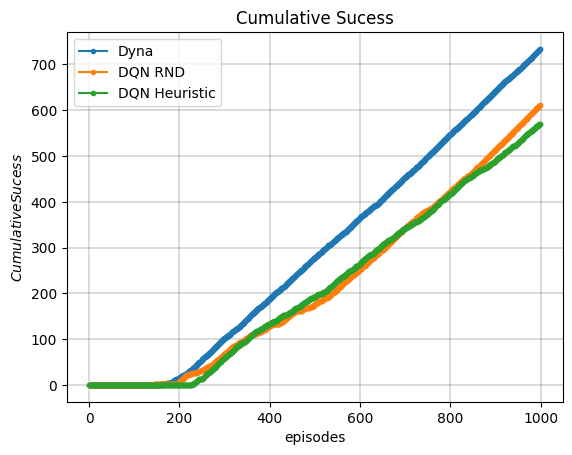

In [65]:
cumulative_success_Dyna = [np.sum(Dyna.success_episodes[:ep]) for ep in range(episodes)]

fig5,ax5 = plt.subplots(1,1)
ax5.plot(range(len(cumulative_success_Dyna)), cumulative_success_Dyna[:], marker='.', label="Dyna")
ax5.plot(range(cumulativeHistoryRND.shape[0]), cumulativeHistoryRND[:], marker='.', label="DQN RND")
ax5.plot(range(cumulativeHistoryHeur.shape[0]), cumulativeHistoryHeur[:], marker='.', label="DQN Heuristic")
ax5.set_title(f'Cumulative Sucess')
ax5.set_xlabel(r'episodes')
ax5.set_ylabel(r'$CumulativeSucess$')
ax5.set_xscale('linear')
ax5.set_yscale('linear')
ax5.legend()
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeSucessALL.png', format='png')


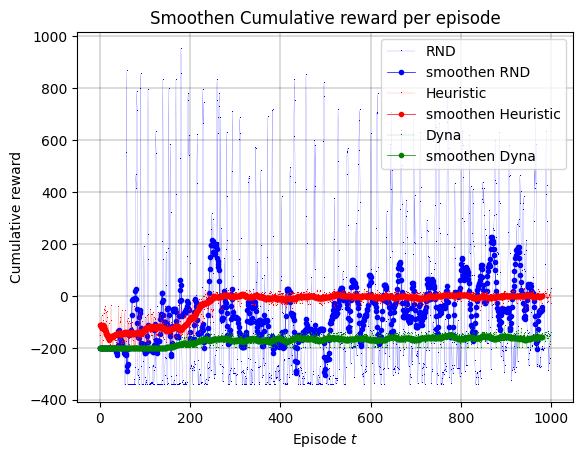

In [66]:
window = 20

reward_Dyna = Dyna.epReward
average_data_Dyna = []
for i in range(len(reward_Dyna) - window + 1):
    average_data_Dyna.append(np.mean(reward_Dyna[i:i+window]))

average_data_heur = []
for i in range(len(episodesHistoryHeur) - window + 1):
    average_data_heur.append(np.mean(episodesHistoryHeur[i:i+window]))

average_data_RND = []
for i in range(len(episodesHistoryRND) - window + 1):
    average_data_RND.append(np.mean(episodesHistoryRND[i:i+window]))

fig1,ax1 = plt.subplots(1,1)
ax1.plot(range(len(episodesHistoryRND)), episodesHistoryRND, color='b', marker=',',linewidth = 0.1, label="RND")
ax1.plot(range(len(average_data_RND)), average_data_RND, color='b', marker='.',linewidth = 0.5, label="smoothen RND")
ax1.plot(range(len(episodesHistoryHeur)), episodesHistoryHeur, color='r', marker=',',linewidth = 0.1, label="Heuristic")
ax1.plot(range(len(average_data_heur)), average_data_heur, color='r', marker='.',linewidth = 0.5, label="smoothen Heuristic")
ax1.plot(range(len(reward_Dyna)), reward_Dyna, color='g', marker=',',linewidth = 0.1, label="Dyna")
ax1.plot(range(len(average_data_Dyna)), average_data_Dyna, color='g',  marker='.',linewidth = 0.5, label="smoothen Dyna")

ax1.set_title(f'Smoothen Cumulative reward per episode')
ax1.set_xlabel(r'Episode $t$')
ax1.set_ylabel('Cumulative reward')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.legend()
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeRewardPerALL_ep{episodes}_rf{reward_factor}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')


In [74]:
episodes = 1000
seed=np.random.randint(1000, size=episodes)
print(seed)

[743 488 254 306 462 540 812 369 661 805 769 429 408 600 611 739 627 663
 933 933 846 943 136 925 180 622 787 827 228 457   2 967 137  44 976 806
 412 681  26 416 419   9 245 478 870 272 688 287 937 194 228 688 674 435
 915 263 386 796 164 163 135 273 385  34 653 680 672 132 709 533 894 646
 830 613 315 306 847 466 788 276   2 446 975 597 203 227 219 704 324 997
  56  68 410 799 183  75 971 480 341 918  26 276 573 735 749 198 209 900
 744 267 408 647 709 867 122 768 628 953  22 287 179 746 622 417 200 767
 537 229 328 128 133 883 522 334 831 113  71 106 954 359 892 886 781 609
 450 252 732 418 763 326 495 267 274  83 838 622 204 291 386 814 304 788
 292 742 599 199 777 660 886 425 401 936 661 398 223  88 522 294 818 708
   6 683 782  80 216 125 998 342 578 890 709 633 116 128 315 592 469 892
 856 465 279 226 112  88 416 649 236 353 931  79 880 222 350 545 994 681
 907 685 876 981 997 668 152 362 538 348 847 740 287 894 711 452 673 288
 354 727 537  68 140 616 101 102 138 393  69 354 16

In [68]:
episodesHistoryHeur, rewardHistoryHeur, cumulativeHistoryHeur, durationHistoryHeur = DQN_heur.play(seed)

100%|██████████| 1000/1000 [00:24<00:00, 41.35it/s]


In [69]:
episodesHistoryRND, rewardHistoryRND, cumulativeHistoryRND, durationHistoryRND = DQN_rnd.play(seed)

100%|██████████| 1000/1000 [04:04<00:00,  4.10it/s]


In [70]:
episodesHistoryDyna, rewardHistoryDyna, cumulativeHistoryDyna, durationHistoryDyna = Dyna.play(seed)

100%|██████████| 1000/1000 [00:05<00:00, 194.22it/s]


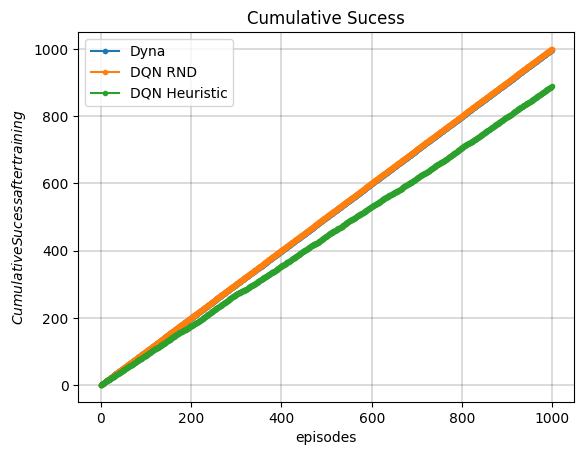

In [71]:
fig5,ax5 = plt.subplots(1,1)
ax5.plot(range(cumulativeHistoryDyna.shape[0]), cumulativeHistoryDyna[:], marker='.', label="Dyna")
ax5.plot(range(cumulativeHistoryRND.shape[0]), cumulativeHistoryRND[:], marker='.', label="DQN RND")
ax5.plot(range(cumulativeHistoryHeur.shape[0]), cumulativeHistoryHeur[:], marker='.', label="DQN Heuristic")
ax5.set_title(f'Cumulative Sucess')
ax5.set_xlabel(r'episodes')
ax5.set_ylabel(r'$CumulativeSucess after training$')
ax5.set_xscale('linear')
ax5.set_yscale('linear')
ax5.legend()
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeSucessTestALL.png', format='png')


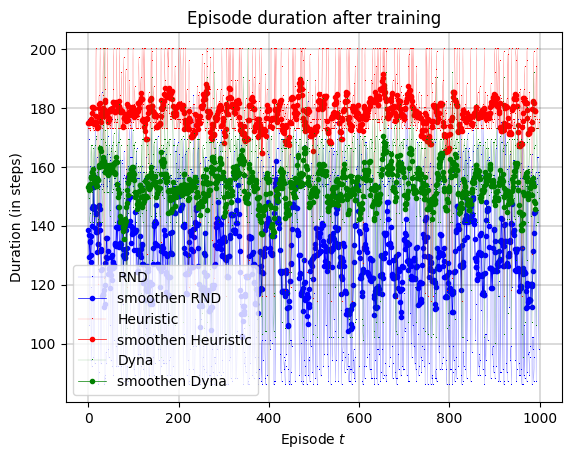

In [72]:
window = 10

average_data_Dyna = []
for i in range(len(durationHistoryDyna) - window + 1):
    average_data_Dyna.append(np.mean(durationHistoryDyna[i:i+window]))

average_data_heur = []
for i in range(len(durationHistoryHeur) - window + 1):
    average_data_heur.append(np.mean(durationHistoryHeur[i:i+window]))

average_data_RND = []
for i in range(len(durationHistoryRND) - window + 1):
    average_data_RND.append(np.mean(durationHistoryRND[i:i+window]))

fig1,ax1 = plt.subplots(1,1)
ax1.plot(range(len(durationHistoryRND)), durationHistoryRND, color='b', marker=',',linewidth = 0.1, label="RND")
ax1.plot(range(len(average_data_RND)), average_data_RND, color='b', marker='.',linewidth = 0.5, label="smoothen RND")
ax1.plot(range(len(durationHistoryHeur)), durationHistoryHeur, color='r', marker=',',linewidth = 0.1, label="Heuristic")
ax1.plot(range(len(average_data_heur)), average_data_heur, color='r', marker='.',linewidth = 0.5, label="smoothen Heuristic")
ax1.plot(range(len(durationHistoryDyna)), durationHistoryDyna, color='g', marker=',',linewidth = 0.1, label="Dyna")
ax1.plot(range(len(average_data_Dyna)), average_data_Dyna, color='g',  marker='.',linewidth = 0.5, label="smoothen Dyna")

ax1.set_title(f'Episode duration after training')
ax1.set_xlabel(r'Episode $t$')
ax1.set_ylabel('Duration (in steps)')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.legend()
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/EpDurationTestALL_ep{durationHistory.shape[0]}_rf{reward_factor}.png', format='png')


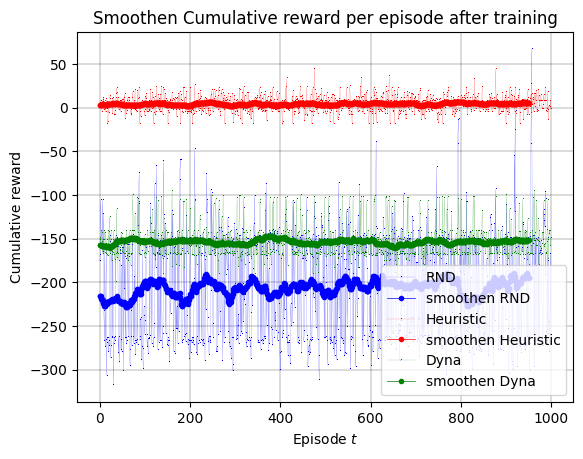

In [73]:
window = 50

average_data_Dyna = []
for i in range(len(episodesHistoryDyna) - window + 1):
    average_data_Dyna.append(np.mean(episodesHistoryDyna[i:i+window]))

average_data_heur = []
for i in range(len(episodesHistoryHeur) - window + 1):
    average_data_heur.append(np.mean(episodesHistoryHeur[i:i+window]))

average_data_RND = []
for i in range(len(episodesHistoryRND) - window + 1):
    average_data_RND.append(np.mean(episodesHistoryRND[i:i+window]))

fig1,ax1 = plt.subplots(1,1)
ax1.plot(range(len(episodesHistoryRND)), episodesHistoryRND, color='b', marker=',',linewidth = 0.1, label="RND")
ax1.plot(range(len(average_data_RND)), average_data_RND, color='b', marker='.',linewidth = 0.5, label="smoothen RND")
ax1.plot(range(len(episodesHistoryHeur)), episodesHistoryHeur, color='r', marker=',',linewidth = 0.1, label="Heuristic")
ax1.plot(range(len(average_data_heur)), average_data_heur, color='r', marker='.',linewidth = 0.5, label="smoothen Heuristic")
ax1.plot(range(len(episodesHistoryDyna)), episodesHistoryDyna, color='g', marker=',',linewidth = 0.1, label="Dyna")
ax1.plot(range(len(average_data_Dyna)), average_data_Dyna, color='g',  marker='.',linewidth = 0.5, label="smoothen Dyna")

ax1.set_title(f'Smoothen Cumulative reward per episode after training')
ax1.set_xlabel(r'Episode $t$')
ax1.set_ylabel('Cumulative reward')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.legend()
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeRewardPerTestsALL_ep{episodes}_rf{reward_factor}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')


## Dyna Agent


In [ ]:
class DynaAgent(Agent):
    
    def __init__(self, id, env=gym.make('MountainCar-v0'), epsilonMax = 0.9, epsilonMin = 0.05, discr_step = np.array([0.025, 0.02]), gamma = 0.99, k=0, k_fixed = True, coeff = 1, change_for_x=False, change_for_v=False, mult=False, div=False):
        Agent.__init__(self,id,env)
        self.discr_step = discr_step
        self.n_xbins = np.round(((self.env.observation_space.high - self.env.observation_space.low)/self.discr_step)[0]).astype(np.int32)
        print(self.n_xbins)
        self.n_vbins = np.round(((self.env.observation_space.high - self.env.observation_space.low)/self.discr_step)[1]).astype(np.int32)
        print(self.n_vbins)
        self.n_states = self.n_xbins*self.n_vbins
        self.n_actions = 3
        self.gamma = gamma
        self.epsilon = epsilonMax
        self.epsilonMax = epsilonMax
        self.epsilonMin = epsilonMin
        self.k = k
        self.k_fixed = k_fixed
        self.terminal_x_bin = self.discretize_x(0.5)*self.n_vbins
        
        '''
        Definition for the plots
        '''        
        self.max_x = -2 
        self.min_x = 1 
        self.max_v = -0.1
        self.min_v = 0.1
        self.time_episodes = []
        self.visited_states = []
        self.important_episodes = []
        self.auxiliary_reward_ep = 0
        self.auxiliary_reward = []
        self.episodesHistory = []
        self.success_episodes = []
        self.mean_Q_evolution = []
        self.update_Q_step = {i: [0, 0] for i in range(200)}
        self.visited_state_action = set()
        self.Y_max_x_episodes = []
        self.Y_min_x_episodes = []
        self.Y_max_v_episodes = []
        self.Y_min_v_episodes = []
        self.coeff = coeff
        self.change_for_x = change_for_x
        self.change_for_v = change_for_v
        self.mult = mult
        self.div = div

        if change_for_x:
            if mult:
                self.discr_step[0]*=coeff
            else:
                if div:
                    self.discr_step[0]/=coeff
            
        if change_for_v:
            if mult:
                self.discr_step[1]*=coeff
            else :
                if div:
                    self.discr_step[1]/=coeff

            
        '''
        Definition of the key variables
        '''
        self.N = np.zeros((self.n_states, self.n_actions, self.n_states))
        
        self.P = np.zeros(shape=(self.n_states, self.n_actions, self.n_states))
        for i in range(self.n_states):
            for j in range(self.n_actions):
                random = np.random.rand(self.n_states)
                self.P[i, j, :] = random/random.sum()
        
        self.R = - np.ones(shape=(self.n_states, self.n_actions))
        for state in range(self.terminal_x_bin, self.n_states):
            self.R[state, :] = 0
        
        self.Q = np.zeros(shape=(self.n_states, self.n_actions))

    
    def discretize_x(self, x):
        x_bin = np.round(((x - self.env.observation_space.low)/self.discr_step)[0]).astype(np.int32)
        return x_bin

    def discretize_v(self, v):
        v_bin = np.round(((v - self.env.observation_space.low)/self.discr_step)[1]).astype(np.int32)
        return v_bin 

    def discretize(self, state):
        x_bin = self.discretize_x(state[0])
        v_bin = self.discretize_v(state[1])
        return x_bin*self.n_vbins + v_bin

    
    def update(self, state, action, next_state, reward):
       
        discr_state, discr_next_state = self.discretize(state), self.discretize(next_state)

        self.visited_states.append(state)
        self.visited_state_action.add((discr_state,action))
        self.N[discr_state,action, discr_next_state] += 1

        
        total_visited = self.N[discr_state,action,:].sum()

        if total_visited > 0:
            self.P[discr_state, action, :] = self.N[discr_state, action,  :] / total_visited
            self.R[discr_state, action] = (self.R[discr_state, action]*(total_visited-1) + reward) / total_visited

        self.auxiliary_reward_ep += self.R[discr_state, action]

        if discr_state < self.terminal_x_bin:
            self.Q[discr_state, action] = reward + (self.gamma)*(self.P[discr_state, action,:]*np.max(self.Q, axis = 1)[:]).sum()
        else:
            self.Q[discr_state, action] = reward

        update = self.Q[discr_state, action] - reward
        self.update_Q_step[self.step][0] += update
        self.update_Q_step[self.step][1] += 1

        if not self.k_fixed:
            self.k = len(self.visited_state_action) // 10
            print("K changes")
            
        sampled_states = []
        if self.k >= 1:
            sampled_states = random.choices(list(self.visited_state_action), k = self.k)

            for (random_state, random_action) in sampled_states:
                if random_state < self.terminal_x_bin:
                    self.Q[random_state, random_action] = self.R[random_state, random_action] + (self.gamma)*(self.P[random_state, random_action,:]*np.max(self.Q, axis = 1)[:]).sum()
                else:
                    self.Q[random_state, random_action] = self.R[random_state, random_action]
                    
                update =  self.Q[random_state, random_action] - self.R[random_state, random_action]
                self.update_Q_step[self.step][0] += update
                self.update_Q_step[self.step][1] += 1

    

    def observe(self):
        pass
    
    def select_action(self, state):
        state_bin = self.discretize(state)
        p = random.uniform(0,1)
        a=0
        if p < 1-self.epsilon :
            a = np.argmax(self.Q[state_bin,:])
        else:
            a = random.randint(0,2)
            
        return a

    
    '''
    Select actions without exploration (for the tests)
    '''  
    def select_best_action(self, state):
        state_bin = self.discretize(state)
        return np.argmax(self.Q[state_bin,:])

    
    '''
    Test the agent on a seed (random or not) after the training
    '''  
    def play(self, seed = False):
        newSeed = random.randint(0,100000)
        
        if seed != False:
            newSeed = seed
            
        state,_ = self.env.reset(seed = newSeed)
        done = False
                    
        while done == False:
                                        
            action = self.select_best_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            state = next_state
            done = terminated or truncated
        self.env.close()


    
    def train(self, episodes, debug_mode=True, epsilon_decrease=True, epsilonDecreasing=100):
        
        self.episodesHistory = np.zeros((episodes))
        
        for i in tqdm(range(episodes)):
            
            #start_time = time.time()
            
            if epsilon_decrease: 
                if self.epsilon > self.epsilonMin:
                    self.epsilon = self.epsilonMax*math.exp(-i/epsilonDecreasing)
            else:
                self.epsilon = self.epsilonMax
                
            newSeed = random.randint(0,100000)
            state,_ = self.env.reset(seed = newSeed)
            
            done = False
            episode_reward = 0
            actual_episode_for_Q = []
            self.step = 0
            
            while not done:
                
                if self.max_x < state[0]:
                    self.max_x = state[0]
                if self.min_x > state[0]:
                    self.min_x = state[0]

                if self.max_v < state[1]:
                    self.max_v = state[1]
                if self.min_v > state[1]:
                    self.min_v = state[1]
                    
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                
                self.update(state, action, next_state, reward)
        
                discr_state = self.discretize(state)
                max_value = np.max(self.Q[discr_state, :])
                actual_episode_for_Q.append((state, max_value))
                                             
                episode_reward += reward
                state = next_state
                self.step += 1
                done = terminated or truncated

            #stop_time = time.time()
            #episode_time = stop_time-start_time
            episode_time = -episode_reward
                
            self.auxiliary_reward.append(self.auxiliary_reward_ep)
            self.auxiliary_reward_ep = 0
            
            self.time_episodes.append(episode_time)
            if (i%500 == 0 or i == 10 or i == 100):  # episodes marquants considérés 
                self.important_episodes.append((actual_episode_for_Q, episode_time, episode_reward, i))
            if terminated:
                print("Terminated")
                self.important_episodes.append((actual_episode_for_Q, episode_time, episode_reward, i))
                self.success_episodes.append(1)
            else:
                self.success_episodes.append(0)

            mean_max_q = np.sum([value[1] for value in actual_episode_for_Q]) / (-episode_reward)
            self.mean_Q_evolution.append(mean_max_q)
                
            if debug_mode: print("Episode "+str(i+1)+ " , Reward: "+str(episode_reward)+" Epsilon: "+str(self.epsilon))
            self.episodesHistory[i] = episode_reward

            self.Y_max_x_episodes.append(self.max_x)
            self.Y_min_x_episodes.append(self.min_x)
            self.Y_max_v_episodes.append(self.max_v)
            self.Y_min_v_episodes.append(self.min_v)
                
        return 

  



In [ ]:
A = DynaAgent("id0", k = 200)
A.train(3000, debug_mode=True)

## Question 1

In [ ]:
def informations_about_terminated(group_size, success_episodes):
    number_episodes = len(success_episodes)
    number_bar = number_episodes // group_size
    
    percentages_of_agent_resolution = [
        sum(success_episodes[:(i+1)*group_size]) / ((i+1)*group_size)
        for i in range(number_bar)
    ]
    percentages_of_agent_resolution = 100 * np.array(percentages_of_agent_resolution)
    
    total_episodes_until_group = [(i + 1) * group_size for i in range(number_bar)]
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.bar(total_episodes_until_group, percentages_of_agent_resolution, width=group_size*0.8)
    ax.set_title(f'Evolution of the percentage of task resolution by the agent every {group_size} episodes\nTotal number of episodes: {group_size * number_bar}')
    ax.set_xlabel('Number of episodes')
    ax.set_ylabel('Percentage of task resolution by the agent')
    ax.set_ylim(0, 100)  

    
    for i, v in zip(total_episodes_until_group, percentages_of_agent_resolution):
        ax.text(i + 1, v + 1, f"{int(round(v))}%" ,ha='center', va='bottom', size=4)

    try:
        first_resolution = success_episodes.index(1)
        ax.text(0.5, -0.15, f'The agent solves the task for the first time in episode number {first_resolution}.', 
                transform=ax.transAxes, fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
    except ValueError:
        ax.text(0.5, -0.15, 'The agent never solves the task.', 
                transform=ax.transAxes, fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

## Question 2

In [ ]:
def variation_size_bins_plot(Y_max_x_episodes, Y_min_x_episodes, Y_max_v_episodes,  Y_min_v_episodes):

    """
    Cette fonction trace les plots avec :
    - en abscisse le nombre d'épisodes 
    - en ordonnée, soit le x, soit le v maximal (ou minimal) atteint 
    (pour un total de 4 plots donc)
    
    """
    
    number_points = len(Y_max_x_episodes)
    X_plot = np.arange(number_points)

    fig, ((ax1a, ax1b), (ax2a, ax2b)) = plt.subplots(2, 2)

    ax1a.plot(X_plot, Y_max_x_episodes)
    ax1a.set_xlabel(r'Number of episode')
    ax1a.set_ylabel(r'Max x reached')
    ax1a.set_title(r'Farthest x reached by number of episodes')  
    
    ax1b.plot(X_plot, Y_min_x_episodes)
    ax1b.set_xlabel(r'Number of episode')
    ax1b.set_ylabel(r'Min x reached')
    ax1b.set_title(r'Smallest x reached by number of episodes') 
    
    ax2a.plot(X_plot, Y_max_v_episodes)
    ax2a.set_xlabel(r'Number of episode')
    ax2a.set_ylabel(r'Max v reached')
    ax2a.set_title(r'Farthest v reached by number of episodes')  
    
    
    ax2b.plot(X_plot, Y_min_v_episodes)
    ax2b.set_xlabel(r'Number of episode')
    ax2b.set_ylabel(r'Min v reached')
    ax2b.set_title(r'Smallest v reached by number of episodes') 
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=2, hspace=0.5)
    
    plt.show()
    
      


    

In [ ]:
B = DynaAgent("id2", k = 200, coeff=2, change_for_x=True, change_for_v=True, mult=True, div=False)
B.train(1000, debug_mode=False)
variation_size_bins_plot(B.Y_max_x_episodes, B.Y_min_x_episodes, B.Y_max_v_episodes,  B.Y_min_v_episodes)



## Question 3

In [ ]:
def accumulated_to_index(epList):
    tot_ep = len(epList)
    return [np.sum(epList[:nb_ep]) for nb_ep in range(tot_ep)]



def plot_rewards(episodesHistory, auxiliary_reward):

    nb_episodes = len(episodesHistory)
    T = np.arange(1, nb_episodes+1, 1)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.4, wspace=0.4) 

    
    ax1.plot(T, episodesHistory, marker='.')
    ax1.set_title(f'Total environment reward per episode')
    ax1.set_xlabel(r'Episode number')
    ax1.set_ylabel(r'Total environment reward')
    ax1.set_xscale('linear')
    ax1.set_yscale('linear')

    ax2.plot(T, auxiliary_reward, marker='.')
    ax2.set_title(f'Total auxiliary reward per episode')
    ax2.set_xlabel(r'Episode number')
    ax2.set_ylabel(r'Total auxiliary reward')
    ax2.set_xscale('linear')
    ax2.set_yscale('linear')

    accumulated_episodesHistory = accumulated_to_index(episodesHistory)
    accumulated_auxiliary_reward = accumulated_to_index(auxiliary_reward)

    ax3.plot(T, accumulated_episodesHistory, marker='.')
    ax3.set_title(f'Total accumulated environment reward per episode')
    ax3.set_xlabel(r'Episode number')
    ax3.set_ylabel(r'Total accumulated environment reward')
    ax3.set_xscale('linear')
    ax3.set_yscale('linear')

    ax4.plot(T, accumulated_auxiliary_reward, marker='.')
    ax4.set_title(f'Total accumulated auxiliary reward per episode')
    ax4.set_xlabel(r'Episode number')
    ax4.set_ylabel(r'Total accumulated auxiliary reward')
    ax4.set_xscale('linear')
    ax4.set_yscale('linear')

    a, b = np.polyfit(T,  accumulated_auxiliary_reward, 1)
    ax4.plot(T, a*T + b, linestyle='--', color='red')   

    accumulated_auxiliary_reward_pred = a*T + b
    r_squared = r2_score(accumulated_auxiliary_reward,  accumulated_auxiliary_reward_pred)

    print(f"Leading coefficient : {a}")
    print(f"Originally ordered : {b}")
    print(f"coefficient of determination : {r_squared}")

    plt.tight_layout()
    plt.show()

    


    

In [ ]:
plot_rewards(A.episodesHistory, A.auxiliary_reward)

In [ ]:
def cumulative_number_of_successes(success_episodes):
    
    nb_ep = len(success_episodes)
    cumulative_success = [np.sum(success_episodes[:ep]) for ep in range(nb_ep)]

    fig1,ax1 = plt.subplots(1,1)
    ax1.scatter(range(nb_ep), cumulative_success, marker='.')

    ax1.set_title('Cumulative number of successes per episode')
    ax1.set_xlabel(r'Episode number')
    ax1.set_ylabel(r'Cumulative number of successes')
    ax1.set_xscale('linear')
    ax1.set_yscale('linear')

    a, b = np.polyfit(range(nb_ep), cumulative_success, 1)
    ax1.plot(range(nb_ep), a*range(nb_ep) + b, linestyle='--', color='red')   

    cumulative_success_pred = a*range(nb_ep) + b
    r_squared = r2_score(cumulative_success, cumulative_success_pred)

    print(f"Leading coefficient : {a}")
    print(f"Originally ordered : {b}")
    print(f"coefficient of determination : {r_squared}")
    

In [ ]:
cumulative_number_of_successes(A.success_episodes)

In [ ]:
def plot_update_Q_step(update_Q_step):

    mean_updates_Q = [(update_Q_step[i][0]/update_Q_step[i][1]) for i in range(200)]

    fig1,ax1 = plt.subplots(1,1)
    ax1.plot(range(200),  mean_updates_Q)
    ax1.set_title('Average Q update over episodes at each step')
    ax1.set_xlabel(r'Step number')
    ax1.set_ylabel(r'Average Q update over episodes')
    ax1.set_xscale('linear')
    ax1.set_yscale('linear')
    
    

In [ ]:
plot_update_Q_step(A.update_Q_step)

## Question 5

In [ ]:
def plot_time_duration_episodes(time_episodes):
    
    X = np.arange(1, len(time_episodes) + 1)
    T = np.array(time_episodes)

    for_clustering = np.array(list(zip(X, T)))
    
    kmeans = KMeans(n_clusters=3)
    labels_for_plot = kmeans.fit_predict(for_clustering)

    filtered_label0 = for_clustering[labels_for_plot == 0]
    filtered_label1 = for_clustering[labels_for_plot == 1]
    filtered_label2 = for_clustering[labels_for_plot == 2]

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    ax.scatter(filtered_label0[:, 0], filtered_label0[:, 1], marker='.', color='red', label='Cluster 0')
    ax.scatter(filtered_label1[:, 0], filtered_label1[:, 1], marker='.', color='blue', label='Cluster 1')
    ax.scatter(filtered_label2[:, 0], filtered_label2[:, 1], marker='.', color='green', label='Cluster 2')
    
    ax.set_title('Evolution of episode duration')
    ax.set_xlabel('Episode number')
    ax.set_ylabel('Number of steps')
    ax.legend()

    plt.show()



In [ ]:
plot_time_duration_episodes(A.time_episodes)

## Questions 6 and 7

In [ ]:
def two_dimensions_Q_plot(list_states, discretize, Q, important_episodes, with_important_episodes=False):
    # list_states = self.visited_states
    discretized_states = [discretize(state) for state in list_states]

    X = np.array([state[0] for state in list_states])
    V = np.array([state[1] for state in list_states])
    Q_values = [max(Q[discr_state, :]) for discr_state in discretized_states]
    
    # Normalisation des valeurs Q pour le colormap
    Q_values = np.array(Q_values)
    Q_normalized = (Q_values - np.min(Q_values)) / (np.max(Q_values) - np.min(Q_values))

    # Utilisation d'un autre colormap pour voir si les résultats sont meilleurs
    cmap = cm.get_cmap('viridis')
    color = cmap(Q_normalized)

    if not with_important_episodes:
        fig, ax = plt.subplots()

        sc = ax.scatter(X, V, c=Q_normalized, s=2, cmap=cmap, edgecolors='none')
        ax.set_xlabel('Values of x')
        ax.set_ylabel('Values of v')
        ax.set_title('Max Q(s,a) as a function of s = (x, v) in 2D')

        plt.colorbar(sc, label='Normalized Q values')
        plt.show()
    else:
        first_success_ind = -1
        min_step_success_ind = -1
        reward_history = 0
        min = 200
        for i, episode in enumerate(important_episodes):
            reward_history = episode[2]
            if reward_history > -200:
                if first_success_ind == -1:
                    first_success_ind = i
                if -reward_history < min:
                    min = -reward_history
                    min_step_success_ind = i
        
        states_ep = [value[0] for value in important_episodes if value[2] == -200] + [important_episodes[first_success_ind][0]] + [important_episodes[min_step_success_ind][0]]
        ep_number = [value[3] for value in important_episodes if value[2] == -200] + [important_episodes[first_success_ind][3]] + [important_episodes[min_step_success_ind][3]]
        
        nb_total = len(states_ep)
        
        for i, state_ep in enumerate(states_ep):
            fig, ax = plt.subplots()
            plt.scatter(X, V, c=color, s=1)
            sc = ax.scatter(X, V, c=Q_normalized, s=2, cmap=cmap, edgecolors='none')
            plt.colorbar(sc, label='Normalized Q values')
        
            x_ep = [state[0][0] for state in state_ep]
            v_ep = [state[0][1] for state in state_ep]
            
            label = f'Episode number {ep_number[i]} '
            if i == nb_total - 2:
                label += '- First success'
            if i == nb_total - 1:
                label += '- Min step success'
                
            ax.scatter(x_ep, v_ep, color='black', s=10, label=label)
            ax.plot(x_ep, v_ep, color='black', linewidth=1)

            ax.legend()
            ax.set_xlabel('Values of x')

            if i == 0:
                ax.set_ylabel('Values of v')
                ax.set_title('Max Q(s,a) as a function of s = (x, v)')

            plt.show()

In [ ]:
two_dimensions_Q_plot(A.visited_states, A.discretize, A.Q, A.important_episodes, with_important_episodes = True)

## Bonus 

In [ ]:
def mean_Q_evol(mean_Q_evolution):
    
    nb_ep = len(mean_Q_evolution)
    
    fig1,ax1 = plt.subplots(1,1)
    ax1.scatter(range(nb_ep), mean_Q_evolution, s=0.1)
    ax1.set_title('Average max_Q per episode')
    ax1.set_xlabel(r'Episode number')
    ax1.set_ylabel(r'Average max_Q')
    ax1.set_xscale('linear')
    ax1.set_yscale('linear')

In [ ]:
mean_Q_evol(A.mean_Q_evolution)